In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Step # 0**

In [2]:
# ============================================================
# STEP 0 — ENVIRONMENT & LIBRARIES (IMPORTS + VERSION DUMP)
# Cell 1/9 — Run identifiers, paths, and folders
# ------------------------------------------------------------
# Goal:
#   • Define a unique RUN_NAME and basic run knobs (dataset, seed, etc.).
#   • Create standard folders so later steps can write logs/artifacts.
#   • Keep everything identical across models; only MODEL_TAG will change.
# ============================================================
from datetime import datetime
from pathlib import Path

# ---- run knobs (edit per experiment family, same across models except MODEL_TAG) ----
DATASET    = "busi"
IMAGE_SIZE = 256  #512 can be done too
SEED       = 42
BATCH_SIZE = 8
EPOCHS     = 10
AMP_ON     = True                       # mixed precision policy; we keep it consistent
MODEL_TAG  = "unetr_model"         # e.g., TransUNet, TransUNet-Lite-T, TransUNet-Lite-B
RUN_NAME   = f"{MODEL_TAG}_{DATASET}_IMG{IMAGE_SIZE}_SEED{SEED}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
CONFIG_PATH = "configs/example.yaml"    # path to YAML config (snapshot saved later)

# ---- standard folders (created if missing) ----
root = Path("/content/drive/MyDrive/unetr_model_busi")
for p in ["logs", "checkpoints", "figures", "runs", "summary"]:
    (root / p).mkdir(parents=True, exist_ok=True)

summary_txt_path  = root / "summary" / f"{RUN_NAME}_env.txt"
summary_json_path = root / "summary" / f"{RUN_NAME}_env.json"


In [3]:
# ============================================================
# STEP 0 — ENVIRONMENT & LIBRARIES
# Cell 2/9 — Base imports & safe-import helper
# ------------------------------------------------------------
# Goal:
#   • Import stdlib modules used everywhere.
#   • Provide a helper that imports optional libs and records versions
#     without crashing if something is missing.
# ============================================================
import os, sys, json, time, platform, importlib, random

def try_import(name: str):
    """
    Try to import a module by name.
    Returns (module_or_None, version_or_note).
    Never raises; records 'NOT INSTALLED' if missing.
    """
    try:
        mod = importlib.import_module(name)
        ver = getattr(mod, "__version__", "unknown")
        # Package-specific adjustments
        if name == "PIL":   # Pillow
            ver = getattr(mod, "__version__", ver)
        if name == "cv2":   # OpenCV
            ver = getattr(mod, "__version__", ver)
        return mod, ver
    except Exception as e:
        return None, f"NOT INSTALLED ({type(e).__name__})"


In [4]:
!pip install -U monai torchmetrics thop fvcore


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 69.8 MB/s eta 0:00:00
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=f23fd669f791a035c8d982d44e578a8d01773502a2b84fb2f11d7a8ff7792005
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=c6d74071cafe212f80114444580b6536d95001bfe021b7dd6f1d773a6da3cf14
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [5]:
# ============================================================
# STEP 0 — ENVIRONMENT & LIBRARIES
# Cell 3/9 — Import common stack (DL, data, viz, utils)
# ------------------------------------------------------------
# Goal:
#   • Import all common libraries but tolerate missing ones.
#   • Capture each library’s version for the environment snapshot.
# ============================================================
# Core / data
numpy, np_ver         = try_import("numpy")
pandas, pd_ver        = try_import("pandas")

# Deep Learning
torch, torch_ver      = try_import("torch")
torchvision, tv_ver   = try_import("torchvision")
timm, timm_ver        = try_import("timm")
monai, monai_ver      = try_import("monai")
torchmetrics, tm_ver  = try_import("torchmetrics")

# Aug / IO / Viz
albumentations, alb_ver = try_import("albumentations")
cv2, cv2_ver            = try_import("cv2")
PIL, pil_ver            = try_import("PIL")        # Pillow
matplotlib, mpl_ver     = try_import("matplotlib")

# Utils
yaml, yaml_ver       = try_import("yaml")
sklearn, sk_ver      = try_import("sklearn")
psutil, psutil_ver   = try_import("psutil")

# Profiling (for MACs/Params later)
thop, thop_ver       = try_import("thop")
fvcore, fvcore_ver   = try_import("fvcore")


In [6]:
# ============================================================
# STEP 0 — ENVIRONMENT & LIBRARIES
# Cell 4/9 — Device, CUDA/cuDNN, and GPU VRAM discovery
# ------------------------------------------------------------
# Goal:
#   • Decide device: 'cuda' if available else 'cpu'.
#   • Record GPU name and total VRAM in MB/GB.
#   • Record CUDA and cuDNN versions for reproducibility.
# ============================================================
device         = "cpu"
gpu_name       = "N/A"
total_vram_mb  = "N/A"
total_vram_gb  = "N/A"
cuda_version   = "N/A"
cudnn_version  = "N/A"

if torch is not None:
    cuda_available = torch.cuda.is_available()
    device = "cuda" if cuda_available else "cpu"
    cuda_version = getattr(torch.version, "cuda", "N/A")
    try:
        cudnn_version = str(torch.backends.cudnn.version()) if torch.backends.cudnn.is_available() else "N/A"
    except Exception:
        cudnn_version = "N/A"
    if cuda_available:
        try:
            gpu_name = torch.cuda.get_device_name(0)
            props = torch.cuda.get_device_properties(0)
            total_vram_bytes = getattr(props, "total_memory", 0)
            total_vram_mb = round(total_vram_bytes / (1024**2), 2)
            total_vram_gb = round(total_vram_bytes / (1024**3), 2)
        except Exception:
            gpu_name = "Unknown (query failed)"
            total_vram_mb = "Unknown"
            total_vram_gb = "Unknown"


In [7]:
# ============================================================
# STEP 0 — ENVIRONMENT & LIBRARIES
# Cell 5/9 — Reproducibility (seeds + deterministic flags)
# ------------------------------------------------------------
# Goal:
#   • Fix seeds across Python/NumPy/PyTorch.
#   • Turn on deterministic paths where practical to reduce variance.
# ============================================================
random.seed(SEED)
if numpy:
    numpy.random.seed(SEED)

if torch is not None:
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    # Determinism toggles (best effort; some ops remain non-deterministic)
    try:
        torch.use_deterministic_algorithms(True)  # PyTorch ≥ 1.8
    except Exception:
        pass
    try:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except Exception:
        pass


In [8]:
# ============================================================
# STEP 0 — ENVIRONMENT & LIBRARIES
# Cell 6/9 — Assemble environment snapshot dict
# ------------------------------------------------------------
# Goal:
#   • Collect run config, system info, and library versions into one dict.
#   • This dict will be printed and saved as TXT/JSON.
# ============================================================
env_info = {
    "run": {
        "run_name": RUN_NAME,
        "datetime": datetime.now().isoformat(timespec="seconds"),
        "dataset": DATASET,
        "image_size": IMAGE_SIZE,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "amp_on": AMP_ON,
        "seed": SEED,
        "config_path": CONFIG_PATH if Path(CONFIG_PATH).exists() else f"{CONFIG_PATH} (not found)",
    },
    "system": {
        "python": sys.version.split()[0],
        "platform": platform.platform(),
        "device": device,
        "gpu_name": gpu_name,
        "gpu_total_vram_mb": total_vram_mb,
        "gpu_total_vram_gb": total_vram_gb,
        "cuda_version": cuda_version,
        "cudnn_version": cudnn_version,
    },
    "libraries": {
        "torch": torch_ver,
        "torchvision": tv_ver,
        "timm": timm_ver,
        "monai": monai_ver,
        "torchmetrics": tm_ver,
        "numpy": np_ver,
        "pandas": pd_ver,
        "albumentations": alb_ver,
        "opencv-python (cv2)": cv2_ver,
        "Pillow (PIL)": pil_ver,
        "matplotlib": mpl_ver,
        "pyyaml": yaml_ver,
        "scikit-learn": sk_ver,
        "psutil": psutil_ver,
        "thop": thop_ver,
        "fvcore": fvcore_ver,
    },
}


In [9]:
# ============================================================
# STEP 0 — ENVIRONMENT & LIBRARIES
# Cell 7/9 — Pretty print snapshot to console
# ------------------------------------------------------------
# Goal:
#   • Show a neat, bordered block with key run + system info.
#   • Keep identical formatting across models for easy diffing.
# ============================================================
border = "=" * 70
print(border)
print("STEP 0 — ENVIRONMENT & LIBRARIES (IMPORTS + VERSION DUMP)")
print(border)
print(f"Run Name      : {env_info['run']['run_name']}")
print(f"Date/Time     : {env_info['run']['datetime']}")
print(f"Dataset       : {env_info['run']['dataset']}")
print(f"Image Size    : {env_info['run']['image_size']}")
print(f"Batch Size    : {env_info['run']['batch_size']}")
print(f"Epochs        : {env_info['run']['epochs']}")
print(f"AMP (mixed precision): {env_info['run']['amp_on']}")
print(f"Seed          : {env_info['run']['seed']}")
print(f"Config Path   : {env_info['run']['config_path']}")
print("-" * 70)
print(f"Python        : {env_info['system']['python']}")
print(f"Platform      : {env_info['system']['platform']}")
print(f"Device        : {env_info['system']['device']}")
print(f"GPU           : {env_info['system']['gpu_name']}")
print(f"GPU VRAM      : {env_info['system']['gpu_total_vram_mb']} MB "
      f"({env_info['system']['gpu_total_vram_gb']} GB)")
print(f"CUDA / cuDNN  : {env_info['system']['cuda_version']} / {env_info['system']['cudnn_version']}")
print("-" * 70)
print("Libraries:")
for lib, ver in env_info["libraries"].items():
    print(f"  - {lib:<24} {ver}")
print(border)


STEP 0 — ENVIRONMENT & LIBRARIES (IMPORTS + VERSION DUMP)
Run Name      : unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17
Date/Time     : 2025-11-02T10:36:21
Dataset       : busi
Image Size    : 256
Batch Size    : 8
Epochs        : 10
AMP (mixed precision): True
Seed          : 42
Config Path   : configs/example.yaml (not found)
----------------------------------------------------------------------
Python        : 3.12.12
Platform      : Linux-6.6.105+-x86_64-with-glibc2.35
Device        : cuda
GPU           : Tesla T4
GPU VRAM      : 15095.06 MB (14.74 GB)
CUDA / cuDNN  : 12.6 / 91002
----------------------------------------------------------------------
Libraries:
  - torch                    2.8.0+cu126
  - torchvision              0.23.0+cu126
  - timm                     1.0.21
  - monai                    1.5.1
  - torchmetrics             1.8.2
  - numpy                    2.0.2
  - pandas                   2.2.2
  - albumentations           2.0.8
  - opencv-python (cv2)    

In [10]:
# ============================================================
# STEP 0 — ENVIRONMENT & LIBRARIES
# Cell 8/9 — Save TXT + JSON environment snapshots
# ------------------------------------------------------------
# Goal:
#   • Persist the environment snapshot to disk for reproducibility.
#   • TXT for humans; JSON for scripts.
# ============================================================
# TXT
with open(summary_txt_path, "w", encoding="utf-8") as f:
    f.write(border + "\n")
    f.write("STEP 0 — ENVIRONMENT & LIBRARIES (IMPORTS + VERSION DUMP)\n")
    f.write(border + "\n")
    for section, payload in env_info.items():
        f.write(f"[{section.upper()}]\n")
        if isinstance(payload, dict):
            for k, v in payload.items():
                if isinstance(v, dict):
                    f.write(f"  {k}:\n")
                    for kk, vv in v.items():
                        f.write(f"    - {kk}: {vv}\n")
                else:
                    f.write(f"  - {k}: {v}\n")
        f.write("\n")

# JSON
with open(summary_json_path, "w", encoding="utf-8") as f:
    json.dump(env_info, f, indent=2)

print(f"Saved environment snapshots to:\n  • {summary_txt_path}\n  • {summary_json_path}")


Saved environment snapshots to:
  • /content/drive/MyDrive/unetr_model_busi/summary/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_env.txt
  • /content/drive/MyDrive/unetr_model_busi/summary/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_env.json


In [11]:
# ============================================================
# STEP 0 — ENVIRONMENT & LIBRARIES
# Cell 9/9 — Initialize per-run CSV log header
# ------------------------------------------------------------
# Goal:
#   • Create an empty CSV file for epoch logs if it does not exist yet.
#   • This keeps training logs standardized across models.
# ============================================================
csv_path = root / "logs" / f"{RUN_NAME}.csv"
if not csv_path.exists():
    with open(csv_path, "w", encoding="utf-8") as f:
        f.write("epoch,lr,train_loss,val_loss,train_dice,val_dice,train_iou,val_iou,epoch_time\n")
print(f"Initialized log CSV (if new): {csv_path}")


Initialized log CSV (if new): /content/drive/MyDrive/unetr_model_busi/logs/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17.csv


# **Step # 1**

In [12]:
# ============================================================
# STEP 1 — DATASET DOWNLOAD (ISIC 2018, 256px) → MedSegBench cache
# Cell 1/6 — Setup: cache dir, env var, and size
# ------------------------------------------------------------
# Goal:
#   • Set SIZE=256 (image resolution).
#   • Create MedSegBench cache at ~/.medsegbench.
#   • Point MEDSEGBENCH_DIR to the cache so MedSegBench finds the data.
# ============================================================
import os
from pathlib import Path

SIZE = 256
cache_root = Path("/content/data/MedSegBenchCache")
cache_root.mkdir(parents=True, exist_ok=True)
os.environ["MEDSEGBENCH_DIR"] = str(cache_root)  # ensure MedSegBench reads this

print(f"[INFO] MEDSEGBENCH_DIR = {cache_root.resolve()}")
print(f"[INFO] Target resolution = {SIZE}px")


[INFO] MEDSEGBENCH_DIR = /content/data/MedSegBenchCache
[INFO] Target resolution = 256px


In [13]:
!pip install medsegbench

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.3 MB/s eta 0:00:00


In [14]:
# ============================================================
# STEP 1 — DATASET DOWNLOAD
# Cell 2/6 — Dataset source details (Zenodo v1 record)
# ------------------------------------------------------------
# Goal:
#   • Define file name, direct download URL, and official MD5 checksum.
#   • Keep variables explicit for auditability/reproducibility.
# ============================================================
target_name = f"busi_{SIZE}.npz"
target_path = cache_root / target_name

# Zenodo (MedSegBench v1 record) direct file link:
url = f"https://zenodo.org/records/13358372/files/{target_name}?download=1"

# Official MD5 for isic2016_256.npz (from the Zenodo file list)
expected_md5 = "198aea70968b71adf593b32c41a6e995"

print(f"[INFO] Target file  : {target_name}")
print(f"[INFO] Download URL : {url}")
print(f"[INFO] Expected MD5 : {expected_md5}")


[INFO] Target file  : busi_256.npz
[INFO] Download URL : https://zenodo.org/records/13358372/files/busi_256.npz?download=1
[INFO] Expected MD5 : 198aea70968b71adf593b32c41a6e995


In [15]:
# ============================================================
# STEP 1 — DATASET DOWNLOAD
# Cell 3/6 — Helpers (md5sum + download runners)
# ------------------------------------------------------------
# Goal:
#   • Provide md5sum(path) to verify integrity.
#   • Provide a download helper that tries curl, then wget.
# ============================================================
import hashlib, subprocess, shutil

def md5sum(path: Path) -> str:
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

def download_file(url: str, out_path: Path) -> None:
    # Try curl first (quiet progress, follow redirects, fail on HTTP errors)
    curl = shutil.which("curl")
    if curl:
        print("[INFO] Downloading with curl ...")
        subprocess.run([curl, "-L", "-f", url, "-o", str(out_path)], check=True)
        return
    # Fallback: wget
    wget = shutil.which("wget")
    if wget:
        print("[INFO] curl not found; downloading with wget ...")
        subprocess.run([wget, "-O", str(out_path), url], check=True)
        return
    raise RuntimeError("Neither curl nor wget is available on PATH.")


In [16]:
# ============================================================
# STEP 1 — DATASET DOWNLOAD
# Cell 4/6 — Download (idempotent)
# ------------------------------------------------------------
# Goal:
#   • If file is missing → download to cache.
#   • If present → skip download.
# ============================================================
if not target_path.exists():
    print(f"[INFO] Downloading to {target_path} ...")
    try:
        download_file(url, target_path)
    except subprocess.CalledProcessError as e:
        raise RuntimeError(f"Downloader failed with return code {e.returncode}.") from e
else:
    print(f"[INFO] File already present: {target_path}")


[INFO] Downloading to /content/data/MedSegBenchCache/busi_256.npz ...
[INFO] Downloading with curl ...


In [17]:
# ============================================================
# STEP 1 — DATASET DOWNLOAD
# Cell 5/6 — Integrity check (MD5)
# ------------------------------------------------------------
# Goal:
#   • Verify downloaded file integrity using MD5.
#   • Fail fast if checksum mismatches; suggest redownload.
# ============================================================
got = md5sum(target_path)
print(f"[INFO] MD5 (computed): {got}")
if got != expected_md5:
    raise RuntimeError(
        f"MD5 mismatch for {target_name}. Expected {expected_md5}, got {got}.\n"
        "Delete the file and rerun this step to redownload."
    )
print(f"✅ Download + MD5 OK → {target_path}")


[INFO] MD5 (computed): 198aea70968b71adf593b32c41a6e995
✅ Download + MD5 OK → /content/data/MedSegBenchCache/busi_256.npz


In [18]:
# ============================================================
# STEP 1 — DATASET DOWNLOAD
# Cell 6/6 — Ready message
# ------------------------------------------------------------
# Goal:
#   • Confirm dataset is cached and ready for MedSegBench loaders.
#   • Next, we proceed to STEP 2 (repro/config) and STEP 3 (print split counts).
# ============================================================
print("[READY] busi (256px) cached in MEDSEGBENCH_DIR.")
print("[NEXT] STEP 2: Reproducibility & Config Lock; STEP 3: load predefined splits and print counts.")


[READY] busi (256px) cached in MEDSEGBENCH_DIR.
[NEXT] STEP 2: Reproducibility & Config Lock; STEP 3: load predefined splits and print counts.


# **Step # 2**

In [19]:
# ============================================================
# STEP 2 — REPRODUCIBILITY & CONFIG LOCK
# Cell 1/5 — Resolve run knobs, paths, and dataset file
# ------------------------------------------------------------
# Goal:
#   • Reuse run variables from STEP 0 (RUN_NAME, SEED, IMAGE_SIZE, etc.).
#   • Ensure the artifacts root (from STEP 0) is set.
#   • Confirm MEDSEGBENCH_DIR and the ISIC2018 .npz path (from STEP 1).
#   • Decide a config path for this run (create default if missing).
# ============================================================
import os
from pathlib import Path

# Reuse 'root' from STEP 0; if missing, fall back to current folder.
try:
    root
except NameError:
    root = Path(".")

# Reuse vars from STEP 0; if any missing, set conservative defaults.
DATASET    = globals().get("DATASET", "busi")
IMAGE_SIZE = int(globals().get("IMAGE_SIZE", 256))
SEED       = int(globals().get("SEED", 42))
BATCH_SIZE = int(globals().get("BATCH_SIZE", 8))
EPOCHS     = int(globals().get("EPOCHS", 10))
AMP_ON     = bool(globals().get("AMP_ON", True))
MODEL_TAG  = globals().get("MODEL_TAG", "unetr_model")
RUN_NAME   = globals().get("RUN_NAME", f"{MODEL_TAG}_{DATASET}_IMG{IMAGE_SIZE}_SEED{SEED}")
CONFIG_PATH = globals().get("CONFIG_PATH", "configs/example.yaml")

# Decide the resolution used by the cached file (from STEP 1: SIZE=256 or 512).
RESOLUTION = int(globals().get("SIZE", IMAGE_SIZE))  # prefer SIZE from STEP 1, else IMAGE_SIZE

# MedSegBench cache directory & expected file name
msb_dir = Path(os.environ.get("MEDSEGBENCH_DIR", os.path.expanduser("~/.medsegbench")))
busi_file = msb_dir / f"busi_{RESOLUTION}.npz"

print(f"[INFO] Artifacts root        : {root.resolve()}")
print(f"[INFO] MEDSEGBENCH_DIR       : {msb_dir.resolve()}")
print(f"[INFO] Expected busi file    : {busi_file}")
print(f"[INFO] Run                   : {RUN_NAME}")
print(f"[INFO] Model tag             : {MODEL_TAG}")
print(f"[INFO] Seed / ImageSize      : {SEED} / {IMAGE_SIZE}")
print(f"[INFO] Batch / Epochs / AMP  : {BATCH_SIZE} / {EPOCHS} / {AMP_ON}")


[INFO] Artifacts root        : /content/drive/MyDrive/unetr_model_busi
[INFO] MEDSEGBENCH_DIR       : /content/data/MedSegBenchCache
[INFO] Expected busi file    : /content/data/MedSegBenchCache/busi_256.npz
[INFO] Run                   : unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17
[INFO] Model tag             : unetr_model
[INFO] Seed / ImageSize      : 42 / 256
[INFO] Batch / Epochs / AMP  : 8 / 10 / True


In [20]:
# ============================================================
# STEP 2 — REPRODUCIBILITY & CONFIG LOCK
# Cell 2/5 — Seed + deterministic flags (re-assert)
# ------------------------------------------------------------
# Goal:
#   • Set global seeds (Python/NumPy/PyTorch) and deterministic flags.
#   • This mirrors STEP 0, but we re-assert here for clarity/restarts.
# ============================================================
import random

# Optional imports if not in memory from STEP 0
import numpy as np
import torch

def set_global_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Determinism settings (best effort)
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        pass
    try:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except Exception:
        pass

set_global_seed(SEED)
print(f"[OK] Seeds set and deterministic flags applied (seed={SEED}).")


[OK] Seeds set and deterministic flags applied (seed=42).


In [21]:
# ============================================================
# STEP 2 — REPRODUCIBILITY & CONFIG LOCK
# Cell 3/5 — Build default config (if missing) and load it
# ------------------------------------------------------------
# Goal:
#   • If CONFIG_PATH does not exist, create a default YAML config.
#   • Load the config into memory (dict) for downstream steps.
#   • Keep the same schema for all models; only the model block changes.
# ============================================================
import yaml

(root / "configs").mkdir(parents=True, exist_ok=True)

cfg_path = Path(CONFIG_PATH)
if not cfg_path.exists():
    cfg_path = root / "configs" / "default_busi.yaml"

default_cfg = {
    "run": {
        "run_name": RUN_NAME,
        "seed": SEED,
        "amp_on": AMP_ON,
    },
    "data": {
        "dataset": DATASET,
        "resolution": RESOLUTION,           # matches cached file isic2018_<RESOLUTION>.npz
        "medsegbench_dir": str(msb_dir),    # cache location from STEP 1
        "predefined_splits": True           # we rely on MedSegBench's provided splits
    },
    "train": {
        "image_size": IMAGE_SIZE,           # network input (can be == or >= RESOLUTION)
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "num_workers": 4,
        "optimizer": {"name": "adamw", "lr": 3e-4, "weight_decay": 1e-4},
        "scheduler": {"name": "cosine", "warmup_epochs": 5},
        "early_stopping": {"monitor": "val_dice", "patience": 20},
        "mixed_precision": AMP_ON
    },
    "augment": {
        "geometric": {"flip": True, "rotate": True, "scale": True, "elastic": False},
        "appearance": {"brightness_contrast": True, "blur_noise": True},
        "probabilities": {"flip": 0.5, "rotate": 0.3, "scale": 0.3, "brightness_contrast": 0.3, "blur_noise": 0.2}
    },
    "loss": {
        "primary": "dice_bce",
        "weights": {"dice": 0.7, "bce": 0.3}
    },
    "metrics": {
        "threshold": 0.5,
        "report": ["dice", "iou"],          # boundary_dice / hd95 added later if we want (CSV only)
    },
    "logging": {
        "artifacts_root": str(root.resolve()),
        "print_per_epoch_fields": ["epoch","lr","train_loss","val_loss","train_dice","val_dice","train_iou","val_iou","epoch_time"],
        "save_csv_per_epoch": True,
        "save_best_by": "val_dice"
    },
    "model": {
        "name": MODEL_TAG,                  # the only block that changes across models
        "scale": "auto",                    # Tiny / Base handled by MODEL_TAG or separate width/depth params
        "params": {}                        # put width/depth tokens here when we define variants
    }
}

# Write default if missing; otherwise load existing
if not Path(CONFIG_PATH).exists():
    with open(cfg_path, "w", encoding="utf-8") as f:
        yaml.safe_dump(default_cfg, f, sort_keys=False)
    print(f"[INFO] Created default config at: {cfg_path.resolve()}")
else:
    cfg_path = Path(CONFIG_PATH)

with open(cfg_path, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

print(f"[OK] Loaded config from: {cfg_path.resolve()}")
print(f"[INFO] Config run_name: {cfg['run'].get('run_name')}")


[INFO] Created default config at: /content/drive/MyDrive/unetr_model_busi/configs/default_busi.yaml
[OK] Loaded config from: /content/drive/MyDrive/unetr_model_busi/configs/default_busi.yaml
[INFO] Config run_name: unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17


In [22]:
# ============================================================
# STEP 2 — REPRODUCIBILITY & CONFIG LOCK
# Cell 4/5 — Sanity checks: dataset presence & key fields
# ------------------------------------------------------------
# Goal:
#   • Ensure the ISIC2018 .npz exists in MEDSEGBENCH_DIR.
#   • Echo key config fields so runs stay auditable.
# ============================================================
problems = []

if not busi_file.exists():
    problems.append(f"Missing dataset cache file: {busi_file}")

# Minimal required keys
required_keys = [
    ("run", "seed"),
    ("data", "medsegbench_dir"),
    ("data", "resolution"),
    ("train", "batch_size"),
    ("train", "epochs"),
    ("loss", "primary"),
    ("metrics", "threshold"),
    ("model", "name"),
]
for sect, key in required_keys:
    if sect not in cfg or key not in cfg[sect]:
        problems.append(f"Config missing: {sect}.{key}")

if problems:
    print("[WARN] Sanity check issues:")
    for p in problems:
        print(" -", p)
else:
    print("[OK] Dataset file present and config has required keys.")

print(f"[ECHO] Using dataset cache: {busi_file}")
print(f"[ECHO] MEDSEGBENCH_DIR   : {msb_dir}")
print(f"[ECHO] Model name        : {cfg['model']['name']}")
print(f"[ECHO] Loss              : {cfg['loss']['primary']} (weights={cfg['loss'].get('weights')})")
print(f"[ECHO] Metrics threshold : {cfg['metrics']['threshold']}")


[OK] Dataset file present and config has required keys.
[ECHO] Using dataset cache: /content/data/MedSegBenchCache/busi_256.npz
[ECHO] MEDSEGBENCH_DIR   : /content/data/MedSegBenchCache
[ECHO] Model name        : unetr_model
[ECHO] Loss              : dice_bce (weights={'dice': 0.7, 'bce': 0.3})
[ECHO] Metrics threshold : 0.5


In [23]:
# ============================================================
# STEP 2 — REPRODUCIBILITY & CONFIG LOCK
# Cell 5/5 — Snapshot config for this run
# ------------------------------------------------------------
# Goal:
#   • Save an immutable snapshot of the exact config used for this run.
#   • This lives under summary/ so we can cite it in the paper/repo.
# ============================================================
(root / "summary").mkdir(parents=True, exist_ok=True)
cfg_snapshot = root / "summary" / f"{RUN_NAME}_config.yaml"
with open(cfg_snapshot, "w", encoding="utf-8") as f:
    yaml.safe_dump(cfg, f, sort_keys=False)

print(f"[OK] Saved config snapshot to: {cfg_snapshot.resolve()}")
print("[NEXT] STEP 3 will load MedSegBench predefined splits and print sample counts per set (no re-splitting).")
#::contentReference[oaicite:0]{index=0}


[OK] Saved config snapshot to: /content/drive/MyDrive/unetr_model_busi/summary/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_config.yaml
[NEXT] STEP 3 will load MedSegBench predefined splits and print sample counts per set (no re-splitting).


# **Step # 3**

In [24]:
# ============================================================
# STEP 3 — LOAD PREDEFINED SPLITS & PRINT COUNTS (NO RE-SPLIT)
# Cell 1/4 — Resolve paths and open the cached NPZ  [UPDATED]
# ------------------------------------------------------------
# • Prefers runtime cache if `cacheroot` is defined.
# • Falls back to MEDSEGBENCH_DIR, then ~/.medsegbench.
# • Keeps variable names: msb_dir, RESOLUTION, isic_file, npz
# ============================================================
import os
from pathlib import Path
import numpy as np

# Prefer the runtime cache if present; else env; else home
if "cacheroot" in globals():
    msb_dir = Path(globals()["cacheroot"])
else:
    msb_dir = Path(os.environ.get("MEDSEGBENCH_DIR", os.path.expanduser("~/.medsegbench")))

# Keep your RESOLUTION var behavior (fallback to SIZE, then 512)
RESOLUTION = int(globals().get("RESOLUTION", globals().get("SIZE", 512)))

# Your file pattern stays the same (busi + RESOLUTION)
busi_file = msb_dir / f"busi_{RESOLUTION}.npz"
assert busi_file.exists(), f"Expected dataset file not found: {busi_file}"

# Open the NPZ (lazy) — infer_splits will read keys next
npz = np.load(busi_file, allow_pickle=True)
keys = list(npz.keys())
print(f"[INFO] Loaded: {busi_file}")
print(f"[ECHO] MEDSEGBENCH_DIR: {msb_dir.resolve()}")
print(f"[INFO] NPZ keys ({len(keys)}): {keys[:12]}{'...' if len(keys)>12 else ''}")


[INFO] Loaded: /content/data/MedSegBenchCache/busi_256.npz
[ECHO] MEDSEGBENCH_DIR: /content/data/MedSegBenchCache
[INFO] NPZ keys (18): ['train_images_C1', 'train_label_C1', 'train_images_C2', 'train_label_C2', 'test_images_C1', 'test_label_C1', 'test_images_C2', 'test_label_C2', 'val_images_C1', 'val_label_C1', 'val_images_C2', 'val_label_C2']...


In [25]:
# ============================================================
# STEP 3 — LOAD PREDEFINED SPLITS & PRINT COUNTS (NO RE-SPLIT)
# Cell 2/4 (REPLACED) — Infer split format (supports *_label)
# ------------------------------------------------------------
# Goal:
#   • Handle NPZ layouts where labels are stored as '*_label' or '*_labels'
#     (in addition to our previous '*_masks' variants).
#   • If not found, fall back to index-based or 'splits' dict patterns.
# ============================================================
import numpy as np

def _as_list(x):
    if isinstance(x, np.ndarray):
        x = x.tolist()
    if isinstance(x, (list, tuple)):
        return list(x)
    return [x]

def infer_splits(npz_obj):
    k = set(npz_obj.keys())

    # ---------- Case A (images + masks/labels per split) ----------
    def _find_lbl_key(split):
        for suffix in ("masks", "mask", "labels", "label"):
            cand = f"{split}_{suffix}"
            if cand in k:
                return cand
        return None

    have_all_splits = True
    split_meta = {}
    for split in ("train", "val", "test"):
        img_key = f"{split}_images"
        lbl_key = _find_lbl_key(split)
        if img_key in k and lbl_key in k:
            imgs = npz_obj[img_key]
            lbls = npz_obj[lbl_key]
            nimg, nlbl = len(imgs), len(lbls)
            if nimg != nlbl:
                raise RuntimeError(f"{split}: images ({nimg}) != labels ({nlbl})")
            split_meta[split] = {"n": nimg, "img_key": img_key, "lbl_key": lbl_key}
        else:
            have_all_splits = False
            break

    if have_all_splits:
        counts = {s: split_meta[s]["n"] for s in ("train","val","test")}
        idx = {s: list(range(split_meta[s]["n"])) for s in ("train","val","test")}
        return counts, idx, "A(images+labels)"

    # ---------- Case B (global arrays + explicit index lists) ----------
    for tri, vai, tei in [
        ("train_idx","val_idx","test_idx"),
        ("train_indices","val_indices","test_indices"),
        ("split_train","split_val","split_test"),
    ]:
        if tri in k and vai in k and tei in k:
            train_idx = _as_list(npz_obj[tri])
            val_idx   = _as_list(npz_obj[vai])
            test_idx  = _as_list(npz_obj[tei])
            counts = {"train": len(train_idx), "val": len(val_idx), "test": len(test_idx)}
            idx = {"train": train_idx, "val": val_idx, "test": test_idx}
            return counts, idx, "B(indices)"

    # ---------- Case C (a 'splits' dict with ids/indices) ----------
    if "splits" in k:
        splits = npz_obj["splits"].item() if isinstance(npz_obj["splits"], np.ndarray) else npz_obj["splits"]
        def get_any(d, keys):
            for kk in keys:
                if kk in d: return d[kk]
            return None
        train_ids = get_any(splits.get("train", {}), ["ids","indices","idx"])
        val_ids   = get_any(splits.get("val", {}),   ["ids","indices","idx"])
        test_ids  = get_any(splits.get("test", {}),  ["ids","indices","idx"])
        if train_ids is not None and val_ids is not None and test_ids is not None:
            train_ids = _as_list(train_ids)
            val_ids   = _as_list(val_ids)
            test_ids  = _as_list(test_ids)
            counts = {"train": len(train_ids), "val": len(val_ids), "test": len(test_ids)}
            idx = {"train": train_ids, "val": val_ids, "test": test_ids}
            return counts, idx, "C(splits-dict)"

    # ---------- Nothing matched ----------
    raise RuntimeError(
        "Could not infer predefined splits from NPZ. Expected one of:\n"
        "  A) train_images + train_{masks|mask|labels|label}, etc.\n"
        "  B) global arrays + *_idx / *_indices\n"
        "  C) a 'splits' dict with ids/indices"
    )

counts, split_idx, pattern = infer_splits(npz)
print(f"[OK] Split pattern detected: Case {pattern}")


[OK] Split pattern detected: Case A(images+labels)


In [26]:
# ============================================================
# STEP 3 — LOAD PREDEFINED SPLITS (SPEED-UP, OPTIONAL but RECOMMENDED)
# Cell 2.5/4 — Materialize arrays to RAM and rebind `npz`  [NEW]
# ------------------------------------------------------------
# Why:
#   • .npz is a ZIP file; reading items per-sample re-decompresses often.
#   • We copy all arrays once into RAM, then close the zip, and
#     reassign `npz` to a plain dict with the SAME KEYS.
#   • Downstream code keeps using `npz['train_images']` etc. unchanged.
# ============================================================
import numpy as np

# Copy arrays / objects to a RAM dict with identical keys
npz_ram = {}
for k in keys:
    obj = npz[k]
    # If it's a numpy array, slice to force load into RAM; else keep as-is
    try:
        npz_ram[k] = obj[:] if isinstance(obj, np.ndarray) else obj
    except Exception:
        npz_ram[k] = obj

# Close the zip handle and rebind `npz` to the RAM dict
try:
    npz.close()
except Exception:
    pass
npz = npz_ram  # <-- same variable name; downstream remains unchanged

# Small confirmation
def _shape(x):
    return getattr(x, "shape", None)

print("[SPEED] NPZ materialized to RAM. Example shapes:")
for probe in ["train_images","train_label","train_masks","val_images","val_label","test_images","test_label"]:
    if probe in npz:
        print(f"  • {probe}: { _shape(npz[probe]) }")


[SPEED] NPZ materialized to RAM. Example shapes:
  • train_images: (452, 256, 256)
  • train_label: (452, 256, 256)
  • val_images: (64, 256, 256)
  • val_label: (64, 256, 256)
  • test_images: (131, 256, 256)
  • test_label: (131, 256, 256)


In [27]:
# ============================================================
# STEP 3 — LOAD PREDEFINED SPLITS & PRINT COUNTS (NO RE-SPLIT)
# Cell 3/4 — Print counts per set (images + masks if separable)
# ------------------------------------------------------------
# Goal:
#   • Print consistent counts per split as agreed in our setup.
#   • We do not alter the split; we only report it.
# ============================================================
print("[COUNTS] Samples per split (predefined by MedSegBench)")
print(f"  • Train : {counts['train']}")
print(f"  • Val   : {counts['val']}")
print(f"  • Test  : {counts['test']}")


[COUNTS] Samples per split (predefined by MedSegBench)
  • Train : 452
  • Val   : 64
  • Test  : 131


In [28]:
# ============================================================
# STEP 3 — LOAD PREDEFINED SPLITS & PRINT COUNTS (NO RE-SPLIT)
# Cell 4/4 — Save IDs to disk for reproducibility
# ------------------------------------------------------------
# Goal:
#   • Persist the exact IDs/indices for each split to the summary folder.
#   • These files are read-only breadcrumbs for future audits.
# ============================================================
from pathlib import Path

summary_dir = Path(globals().get("root", Path("."))) / "summary"
summary_dir.mkdir(parents=True, exist_ok=True)

def write_list(path: Path, arr):
    with open(path, "w", encoding="utf-8") as f:
        for x in arr:
            f.write(f"{x}\n")

train_ids_path = summary_dir / f"busi_{RESOLUTION}_train_ids.txt"
val_ids_path   = summary_dir / f"busi_{RESOLUTION}_val_ids.txt"
test_ids_path  = summary_dir / f"busi_{RESOLUTION}_test_ids.txt"

write_list(train_ids_path, split_idx["train"])
write_list(val_ids_path,   split_idx["val"])
write_list(test_ids_path,  split_idx["test"])

print("[OK] Saved split ID lists:")
print(f"  • {train_ids_path}")
print(f"  • {val_ids_path}")
print(f"  • {test_ids_path}")
print("[NEXT] STEP 4 will cover preprocessing pipeline (resize/normalize) and identical augmentations.")


[OK] Saved split ID lists:
  • /content/drive/MyDrive/unetr_model_busi/summary/busi_256_train_ids.txt
  • /content/drive/MyDrive/unetr_model_busi/summary/busi_256_val_ids.txt
  • /content/drive/MyDrive/unetr_model_busi/summary/busi_256_test_ids.txt
[NEXT] STEP 4 will cover preprocessing pipeline (resize/normalize) and identical augmentations.


# **Step # 4**

In [29]:
# ============================================================
# STEP 4 — PREPROCESSING & AUGMENTATIONS (IDENTICAL POLICY)
# Cell 1/5 — Imports, constants, and NPZ reload
# ------------------------------------------------------------
# Goal:
#   • Reload the cached ISIC2018_<RESOLUTION>.npz (robust to restarts).
#   • Define normalization and size policy (kept identical for all models).
#   • Reuse counts/split_idx from STEP 3 if present; otherwise re-infer.
# ============================================================
import os
from pathlib import Path
import numpy as np
import torch

# Reuse ENV knobs from previous steps; set safe fallbacks if needed
RESOLUTION = int(globals().get("RESOLUTION", globals().get("SIZE", 512)))
IMAGE_SIZE = int(globals().get("IMAGE_SIZE", RESOLUTION))
BATCH_SIZE = int(globals().get("BATCH_SIZE", 8))

# ImageNet normalization (works well with ViT/DeiT backbones)
NORM_MEAN = (0.485, 0.456, 0.406)
NORM_STD  = (0.229, 0.224, 0.225)

# Locate NPZ (same as STEP 1/3)
msb_dir   = Path(os.environ.get("MEDSEGBENCH_DIR", os.path.expanduser("~/.medsegbench")))
busi_file = msb_dir / f"busi_{RESOLUTION}.npz"
assert busi_file.exists(), f"Expected dataset file not found: {busi_file}"

# Load NPZ
npz = np.load(busi_file, allow_pickle=True)

# Bring in STEP-3 helpers if not in scope, then infer splits
def _as_list(x):
    if isinstance(x, np.ndarray):
        x = x.tolist()
    if isinstance(x, (list, tuple)):
        return list(x)
    return [x]

def _infer_splits(npz_obj):
    k = set(npz_obj.keys())
    # Prefer per-split arrays (images + masks/labels)
    def _find_lbl_key(split):
        for suffix in ("masks","mask","labels","label"):
            cand = f"{split}_{suffix}"
            if cand in k:
                return cand
        return None
    have_all = True
    meta = {}
    for s in ("train","val","test"):
        ik = f"{s}_images"
        lk = _find_lbl_key(s)
        if ik in k and lk in k:
            n = len(npz_obj[ik])
            if n != len(npz_obj[lk]):
                raise RuntimeError(f"{s}: images != labels length")
            meta[s] = {"n": n, "img_key": ik, "lbl_key": lk}
        else:
            have_all = False
            break
    if have_all:
        return {s: meta[s]["n"] for s in meta}, {s: list(range(meta[s]["n"])) for s in meta}

    # Fall back to index lists if present
    for tri, vai, tei in [("train_idx","val_idx","test_idx"),
                          ("train_indices","val_indices","test_indices"),
                          ("split_train","split_val","split_test")]:
        if tri in k and vai in k and tei in k:
            tr = _as_list(npz_obj[tri]); va = _as_list(npz_obj[vai]); te = _as_list(npz_obj[tei])
            return {"train": len(tr), "val": len(va), "test": len(te)}, {"train": tr, "val": va, "test": te}
    raise RuntimeError("Could not re-infer splits; ensure STEP 3 ran successfully.")

# Reuse from STEP 3 if available; else re-infer
if "counts" in globals() and "split_idx" in globals():
    _counts, _split_idx = counts, split_idx
else:
    _counts, _split_idx = _infer_splits(npz)

print(f"[INFO] Using NPZ: {busi_file}")
print(f"[INFO] Image size policy: RESOLUTION={RESOLUTION} → NETWORK INPUT={IMAGE_SIZE}")
print(f"[COUNTS] train={_counts['train']}  val={_counts['val']}  test={_counts['test']}")


[INFO] Using NPZ: /content/data/MedSegBenchCache/busi_256.npz
[INFO] Image size policy: RESOLUTION=256 → NETWORK INPUT=256
[COUNTS] train=452  val=64  test=131


In [30]:
# ============================================================
# STEP 4 — PREPROCESSING & AUGMENTATIONS
# Cell 2/5 — Albumentations transforms (train/val/test)
# ------------------------------------------------------------
# Goal:
#   • Define identical augmentation policy across all models (fairness).
#   • Train: geometric + appearance augs; Val/Test: no augs, only resize/norm.
#   • Always end with Normalize + ToTensor (CHW, float32).
# ============================================================
import importlib

A_mod = importlib.import_module("albumentations")
A = A_mod
try:
    ToTensorV2 = importlib.import_module("albumentations.pytorch").transforms.ToTensorV2
except Exception:
    raise ImportError("albumentations.pytorch.ToTensorV2 is required for tensor conversion.")

# Build resize op:
# If NPZ already matches IMAGE_SIZE, keep a no-op resize; else enforce resize.
resize_ops = []
if IMAGE_SIZE != RESOLUTION:
    resize_ops = [A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, interpolation=1)]  # 1=bilinear

train_tf = A.Compose([
    *resize_ops,
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.15, rotate_limit=15, border_mode=0, p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(blur_limit=(3,5), p=0.15),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.15),
    A.Normalize(mean=NORM_MEAN, std=NORM_STD),
    ToTensorV2(transpose_mask=True),  # mask to (1,H,W) if needed
])

val_tf = A.Compose([
    *resize_ops,
    A.Normalize(mean=NORM_MEAN, std=NORM_STD),
    ToTensorV2(transpose_mask=True),
])

test_tf = val_tf  # identical to val
print("[OK] Transforms configured (train/val/test).")


[OK] Transforms configured (train/val/test).


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-738078582.py:31: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.15),


In [31]:
# ============================================================
# STEP 4 — PREPROCESSING & AUGMENTATIONS
# Cell 3/5 (REPLACED) — Dataset that memory-maps the NPZ
# ------------------------------------------------------------
# Goal:
#   • Avoid worker crashes by using mmap (no full load into RAM).
#   • Still open lazily per process to stay safe with multiprocessing.
# ============================================================
import torch
from torch.utils.data import Dataset

def _label_key_for(split, npz_obj_or_keys):
    if isinstance(npz_obj_or_keys, (set, list, tuple)):
        k = set(npz_obj_or_keys)
    else:
        k = set(npz_obj_or_keys.keys())
    for suf in ("masks","mask","labels","label"):
        cand = f"{split}_{suf}"
        if cand in k:
            return cand
    raise KeyError(f"No label key found for split={split}.")

class ISICNPZDataset(Dataset):
    def __init__(self, npz_path, split: str, indices, transform=None):
        super().__init__()
        self.path = str(npz_path)

        # Peek keys once (single process) to validate
        _peek = np.load(self.path, allow_pickle=True, mmap_mode="r")
        self.img_key = f"{split}_images"
        self.lbl_key = _label_key_for(split, _peek)
        self.length = len(_peek[self.img_key])
        assert self.length == len(_peek[self.lbl_key]), "Images/labels length mismatch."
        _peek.close()

        self.split = split
        self.indices = list(indices)
        self.transform = transform
        self._npz = None  # opened lazily

    def _ensure_open(self):
        if self._npz is None:
            # Memory-map read-only → low RAM & safe across processes
            self._npz = np.load(self.path, allow_pickle=True, mmap_mode="r")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        self._ensure_open()
        i = self.indices[idx]
        img = self._npz[self.img_key][i]  # HxW or HxWx3
        msk = self._npz[self.lbl_key][i]  # HxW

        # Ensure 3-ch image
        if img.ndim == 2:
            img = np.stack([img, img, img], axis=-1)
        # Ensure {0,1} mask
        if msk.max() > 1:
            msk = (msk > 127).astype(np.uint8)

        if self.transform is not None:
            out = self.transform(image=img, mask=msk)
            img_t = out["image"]
            msk_t = out["mask"].unsqueeze(0) if out["mask"].ndim == 2 else out["mask"]
        else:
            img_f = img.astype(np.float32) / 255.0
            img_f = (img_f - np.array(NORM_MEAN)) / np.array(NORM_STD)
            img_t = torch.from_numpy(img_f).permute(2,0,1).contiguous()
            msk_t = torch.from_numpy(msk.astype(np.float32)).unsqueeze(0)

        return img_t, msk_t

    def __del__(self):
        try:
            if self._npz is not None:
                self._npz.close()
        except Exception:
            pass


In [32]:
# ============================================================
# STEP 4 — PREPROCESSING & AUGMENTATIONS
# Cell 4/5 (REPLACED) — DataLoaders with safe settings (CPU)
# ------------------------------------------------------------
# Goal:
#   • Eliminate worker crashes by running single-process first.
#   • If later we enable GPU & need speed, we can raise workers gradually.
# ============================================================
from torch.utils.data import DataLoader
import torch, os

train_ds = ISICNPZDataset(busi_file, "train", _split_idx["train"], transform=train_tf)
val_ds   = ISICNPZDataset(busi_file, "val",   _split_idx["val"],   transform=val_tf)
test_ds  = ISICNPZDataset(busi_file, "test",  _split_idx["test"],  transform=test_tf)

# CPU-safe defaults
num_workers = 2                 # <-- key change
pin = torch.cuda.is_available() # False on CPU

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=num_workers, pin_memory=pin,
                          drop_last=True, prefetch_factor=2, persistent_workers=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=num_workers, pin_memory=pin,
                          drop_last=False, prefetch_factor=2, persistent_workers=True)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False,
                          num_workers=num_workers, pin_memory=pin,
                          drop_last=False, prefetch_factor=2, persistent_workers=True)

# Sanity check
xb, yb = next(iter(train_loader))
print(f"[OK] Train batch shapes: images={tuple(xb.shape)} masks={tuple(yb.shape)}")
print(f"[INFO] num_workers={num_workers}, pin_memory={pin}, batch_size={BATCH_SIZE}")


[OK] Train batch shapes: images=(8, 3, 256, 256) masks=(8, 1, 256, 256)
[INFO] num_workers=2, pin_memory=True, batch_size=8


In [33]:
# ============================================================
# STEP 4 — PREPROCESSING & AUGMENTATIONS
# Cell 5/5 — Policy echo (for the paper/log)
# ------------------------------------------------------------
# Goal:
#   • Echo the fixed preprocessing/augmentation policy so it is recorded in logs.
#   • Reinforces that all models share the *exact* same data pipeline.
# ============================================================
print("[POLICY] Preprocessing/Normalization")
print(f"  • Resize to: {IMAGE_SIZE}x{IMAGE_SIZE} (if different from NPZ {RESOLUTION})")
print(f"  • Normalize (ImageNet): mean={NORM_MEAN}, std={NORM_STD}")
print("[POLICY] Train augmentations")
print("  • HorizontalFlip p=0.5")
print("  • ShiftScaleRotate (±2% shift, ±15% scale, ±15° rotate) p=0.3")
print("  • Brightness/Contrast p=0.3")
print("  • GaussianBlur p=0.15, GaussNoise p=0.15")
print("[POLICY] Val/Test: no augmentations (only resize + normalize)")
print("[READY] DataLoaders prepared (identical across models). Next: STEP 5 (Losses & Metrics definitions).")
#::contentReference[oaicite:0]{index=0}


[POLICY] Preprocessing/Normalization
  • Resize to: 256x256 (if different from NPZ 256)
  • Normalize (ImageNet): mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
[POLICY] Train augmentations
  • HorizontalFlip p=0.5
  • ShiftScaleRotate (±2% shift, ±15% scale, ±15° rotate) p=0.3
  • Brightness/Contrast p=0.3
  • GaussianBlur p=0.15, GaussNoise p=0.15
[POLICY] Val/Test: no augmentations (only resize + normalize)
[READY] DataLoaders prepared (identical across models). Next: STEP 5 (Losses & Metrics definitions).


# **Step # 5**

In [34]:
# ============================================================
# STEP 5 — DATA SANITY VISUALS (BEFORE TRAINING)
# Cell 1/4 — Select fixed training IDs and set output paths
# ------------------------------------------------------------
# Goal:
#   • Use two stable training samples (same across runs).
#   • Apply NO random augmentations for stability (use val_tf pipeline).
#   • Define output files under figures/.
# ============================================================
from pathlib import Path
import os

# Reuse: root, npz, _split_idx, val_tf, NORM_MEAN, NORM_STD, RESOLUTION, IMAGE_SIZE
# Fallbacks if notebook was restarted:
root = Path(globals().get("root", ".")) if "root" in globals() else Path(".")
(root / "figures").mkdir(parents=True, exist_ok=True)

# Choose two fixed training indices (persist across models)
if "PREVIEW_TRAIN_IDS" in globals():
    preview_ids = list(PREVIEW_TRAIN_IDS)[:2]
else:
    # take the first two IDs from the training split
    preview_ids = [int(globals().get("_split_idx", {"train":[0,1]})["train"][0]),
                   int(globals().get("_split_idx", {"train":[0,1]})["train"][1])]

# Output files (consistent naming)
preview1_path = root / "figures" / "data_preview_ex1.png"  # image + GT mask overlay
preview2_path = root / "figures" / "data_preview_ex2.png"  # image + GT boundary outline

print(f"[INFO] Preview training IDs: {preview_ids}")
print(f"[SAVE] {preview1_path}")
print(f"[SAVE] {preview2_path}")


[INFO] Preview training IDs: [0, 1]
[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/data_preview_ex1.png
[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/data_preview_ex2.png


In [35]:
# ============================================================
# STEP 5 — DATA SANITY VISUALS
# Cell 2/4 — Helpers: unnormalize, overlay, and boundary extraction
# ------------------------------------------------------------
# Goal:
#   • Convert normalized tensors → displayable RGB.
#   • Create semi-transparent mask overlays.
#   • Extract a 1-pixel boundary from the mask and overlay it.
# ============================================================
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

def tensor_to_rgb(img_t: torch.Tensor) -> np.ndarray:
    """
    Input: img_t [C,H,W] (float32), normalized with ImageNet stats.
    Output: RGB uint8 [H,W,3] in [0,255] for visualization.
    """
    mean = np.array(NORM_MEAN, dtype=np.float32).reshape(3,1,1)
    std  = np.array(NORM_STD,  dtype=np.float32).reshape(3,1,1)
    if isinstance(img_t, torch.Tensor):
        img = img_t.detach().cpu().numpy()
    else:
        img = img_t
    img = img * std + mean
    img = np.clip(img, 0.0, 1.0)
    img = (img * 255.0).round().astype(np.uint8)
    img = np.transpose(img, (1,2,0))  # CHW -> HWC
    return img

def overlay_mask(image_rgb: np.ndarray, mask_01: np.ndarray, color=(0,255,0), alpha=0.35) -> np.ndarray:
    """
    Semi-transparent mask overlay on RGB image.
    mask_01: [H,W] in {0,1}
    """
    overlay = image_rgb.copy().astype(np.float32)
    color_arr = np.array(color, dtype=np.float32).reshape(1,1,3)
    m = (mask_01.astype(np.float32)[...,None])
    overlay = overlay * (1 - alpha*m) + color_arr * (alpha*m)
    return overlay.clip(0,255).astype(np.uint8)

def mask_boundary(mask_01: np.ndarray) -> np.ndarray:
    """
    Compute a 1-px boundary from a binary mask using morphological gradient.
    Returns a boolean edge map [H,W].
    """
    m = (mask_01.astype(np.uint8) * 255)
    grad = cv2.morphologyEx(m, cv2.MORPH_GRADIENT, np.ones((3,3), np.uint8))
    edge = grad > 0
    return edge

def overlay_boundary(image_rgb: np.ndarray, edge_bool: np.ndarray, color=(255,0,0)) -> np.ndarray:
    """
    Draw boundary pixels in the given color on top of the image.
    """
    out = image_rgb.copy()
    r,g,b = color
    out[edge_bool] = [r,g,b]
    return out


In [36]:
# ============================================================
# STEP 5 — DATA SANITY VISUALS
# Cell 3/4 — Render and save: (1) mask overlay, (2) boundary outline
# ------------------------------------------------------------
# Goal:
#   • Load the two training samples (no random augs; use val_tf).
#   • Save two PNGs: overlay and boundary, one figure per sample (side-by-side).
# ============================================================
# Access raw arrays from NPZ for the selected training IDs
train_imgs_key = "train_images"
# Support label key variants
for lbl_key_cand in ("train_masks","train_mask","train_labels","train_label"):
    if lbl_key_cand in npz:
        train_lbls_key = lbl_key_cand
        break
else:
    raise KeyError("No train label key found among {train_masks, train_mask, train_labels, train_label}.")

def load_pair(idx: int):
    img = npz[train_imgs_key][idx]
    msk = npz[train_lbls_key][idx]
    # Ensure 3-ch image
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)
    # Ensure binary
    if msk.max() > 1:
        msk = (msk > 127).astype(np.uint8)
    # Apply deterministic (no-rand) transforms for stable preview
    out = val_tf(image=img, mask=msk)
    img_t = out["image"]                      # [C,H,W]
    msk_t = out["mask"].unsqueeze(0) if out["mask"].ndim==2 else out["mask"]  # [1,H,W]
    return img_t, msk_t

# Render helper
def render_preview(idx: int, save_path_overlay: Path = None, save_path_boundary: Path = None):
    img_t, msk_t = load_pair(idx)
    rgb = tensor_to_rgb(img_t)                        # [H,W,3] uint8
    mask01 = (msk_t.squeeze().cpu().numpy() > 0.5)    # [H,W] bool

    # (1) Mask overlay (green)
    over = overlay_mask(rgb, mask01.astype(np.uint8), color=(0,255,0), alpha=0.35)

    # (2) Boundary overlay (red)
    edge = mask_boundary(mask01.astype(np.uint8))
    bound = overlay_boundary(rgb, edge, color=(255,0,0))

    # Save side-by-side for each sample
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(over);   axes[0].set_title("Image + GT Mask");     axes[0].axis("off")
    axes[1].imshow(bound);  axes[1].set_title("Image + GT Boundary"); axes[1].axis("off")
    plt.tight_layout()
    # Save the combined figure to the requested path(s)
    # We save two figures per spec names: ex1 (mask overlay) and ex2 (boundary) but combine sample views.
    if save_path_overlay is not None and save_path_boundary is not None:
        # For clarity, save the combined panel once, and also save single panels if needed
        combo_path = save_path_overlay.parent / f"{save_path_overlay.stem}_and_{save_path_boundary.stem}.png"
        fig.savefig(combo_path, dpi=150)
        plt.close(fig)

        # Also save single images (mask-only and boundary-only) per sample index
        plt.imsave(str(save_path_overlay.with_name(f"{save_path_overlay.stem}_sample{idx}.png")), over)
        plt.imsave(str(save_path_boundary.with_name(f"{save_path_boundary.stem}_sample{idx}.png")), bound)
    else:
        plt.close(fig)

# Render for our two fixed IDs
render_preview(preview_ids[0], preview1_path, preview2_path)
render_preview(preview_ids[1], preview1_path, preview2_path)

print("[OK] Saved previews:")
print(f"  • {preview1_path.with_name(preview1_path.stem + f'_sample{preview_ids[0]}.png')}")
print(f"  • {preview1_path.with_name(preview1_path.stem + f'_sample{preview_ids[1]}.png')}")
print(f"  • {preview2_path.with_name(preview2_path.stem + f'_sample{preview_ids[0]}.png')}")
print(f"  • {preview2_path.with_name(preview2_path.stem + f'_sample{preview_ids[1]}.png')}")
print("[READY] Data sanity visuals saved. Next: STEP 6 (Model definition/swap block).")
#::contentReference[oaicite:0]{index=0}


[OK] Saved previews:
  • /content/drive/MyDrive/unetr_model_busi/figures/data_preview_ex1_sample0.png
  • /content/drive/MyDrive/unetr_model_busi/figures/data_preview_ex1_sample1.png
  • /content/drive/MyDrive/unetr_model_busi/figures/data_preview_ex2_sample0.png
  • /content/drive/MyDrive/unetr_model_busi/figures/data_preview_ex2_sample1.png
[READY] Data sanity visuals saved. Next: STEP 6 (Model definition/swap block).


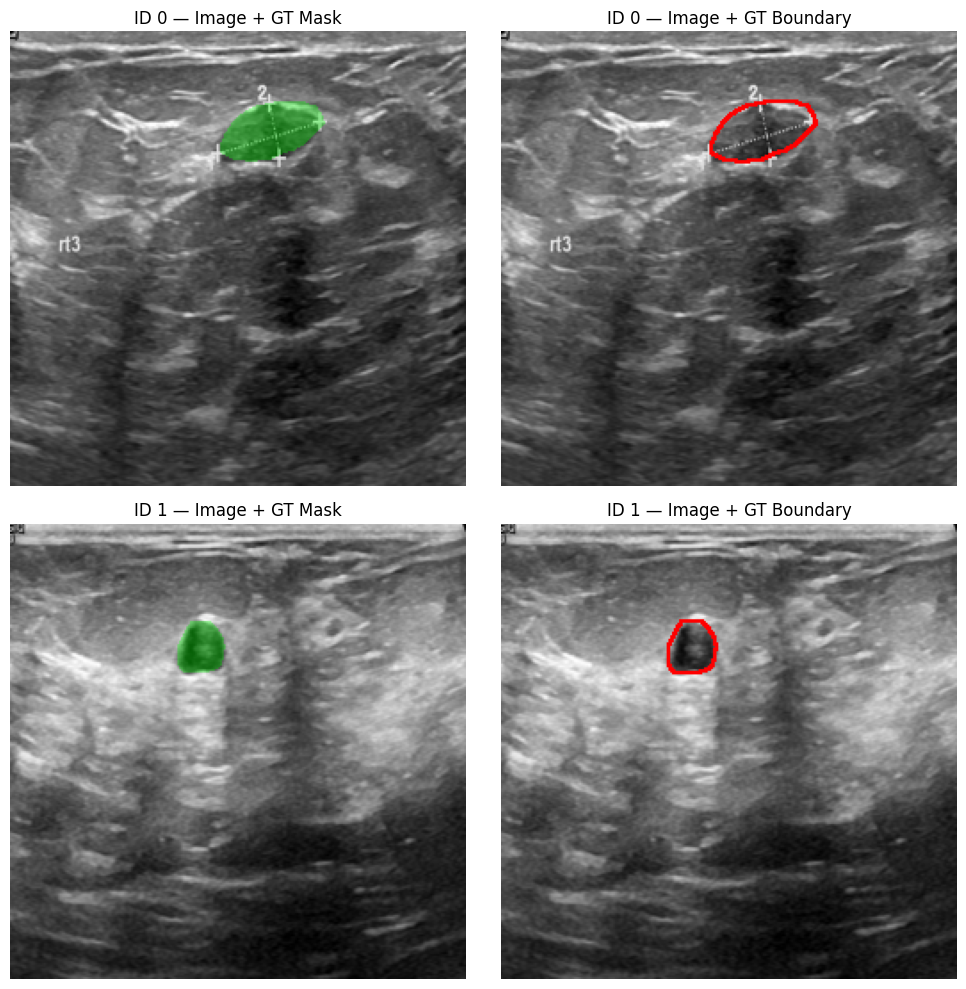

[OK] In-notebook previews rendered (overlay + boundary for both fixed training samples).


In [37]:
# ============================================================
# STEP 5 — DATA SANITY VISUALS (BEFORE TRAINING)
# Cell 4/4 — Quick in-notebook preview (overlay + boundary)
# ------------------------------------------------------------
# Goal:
#   • Display the two fixed training samples directly in the notebook.
#   • Left = Image + GT Mask overlay, Right = Image + GT Boundary outline.
#   • Uses the same deterministic pipeline as the saved previews.
# ============================================================
import matplotlib.pyplot as plt
import numpy as np
import torch

def _render_one(idx: int):
    img_t, msk_t = load_pair(idx)                      # from Cell 3
    rgb   = tensor_to_rgb(img_t)                       # [H,W,3] uint8
    mask01 = (msk_t.squeeze().cpu().numpy() > 0.5)     # [H,W] bool
    over  = overlay_mask(rgb, mask01.astype(np.uint8), color=(0,255,0), alpha=0.35)
    edge  = mask_boundary(mask01.astype(np.uint8))
    bound = overlay_boundary(rgb, edge, color=(255,0,0))
    return over, bound

over0, bound0 = _render_one(preview_ids[0])
over1, bound1 = _render_one(preview_ids[1])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0,0].imshow(over0);  axes[0,0].set_title(f"ID {preview_ids[0]} — Image + GT Mask");     axes[0,0].axis("off")
axes[0,1].imshow(bound0); axes[0,1].set_title(f"ID {preview_ids[0]} — Image + GT Boundary"); axes[0,1].axis("off")
axes[1,0].imshow(over1);  axes[1,0].set_title(f"ID {preview_ids[1]} — Image + GT Mask");     axes[1,0].axis("off")
axes[1,1].imshow(bound1); axes[1,1].set_title(f"ID {preview_ids[1]} — Image + GT Boundary"); axes[1,1].axis("off")
plt.tight_layout()
plt.show()

print("[OK] In-notebook previews rendered (overlay + boundary for both fixed training samples).")


# **Step # 6**

In [38]:
# ============================================================
# STEP 6D — UNETR (paper-style) — Imports & shared blocks
# Cell 1/4
# ------------------------------------------------------------
# Goal:
#   • Use a pretrained ViT-B/16 encoder (timm) and a U-Net decoder.
#   • Keep helpers compatible with our pipeline (ConvBNReLU, UpBlock).
# ============================================================
import torch, torch.nn as nn, torch.nn.functional as F
import timm

# Reuse helpers if already defined elsewhere
if "ConvBNReLU" not in globals():
    class ConvBNReLU(nn.Module):
        def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
            super().__init__()
            self.conv = nn.Conv2d(in_ch, out_ch, k, s, p, bias=False)
            self.bn   = nn.BatchNorm2d(out_ch)
            self.act  = nn.ReLU(inplace=True)
        def forward(self, x): return self.act(self.bn(self.conv(x)))

if "UpBlock" not in globals():
    class UpBlock(nn.Module):
        def __init__(self, in_ch, skip_ch, out_ch):
            super().__init__()
            self.conv1 = ConvBNReLU(in_ch + skip_ch, out_ch)
            self.conv2 = ConvBNReLU(out_ch, out_ch)
        def forward(self, x, skip):
            # upsample x -> skip spatial size, then fuse
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
            x = torch.cat([x, skip], dim=1)
            return self.conv2(self.conv1(x))


In [39]:
# ============================================================
# STEP 6D — UNETR (paper-style) — Model definition
# Cell 2/4
# ------------------------------------------------------------
# Design notes:
#   • We tap 4 transformer depths (≈[3,6,9,12]) via hooks → tokens.
#   • Convert tokens to 1/16 feature maps, then 1×1 project to widths:
#         f0=96, f1=192, f2=384, f3=768  (all at 1/16 stride)
#   • Decoder:
#         l3: 768→384 (deep stream)
#         up2: (384 ⊕ 192) → 192   @ 1/16 → up to 1/8
#         up1: (192 ⊕  96) →  96   @ 1/8  → refine to 1/4 → head
#   • This fixes channel mismatches and keeps shapes explicit.
# ============================================================
class UNETR_PaperStyle(nn.Module):
    def __init__(self, img_size=256, depths=(3,6,9,12)):
        super().__init__()
        # Pretrained ViT-B/16 encoder
        self.vit = timm.create_model(
            "vit_base_patch16_224",
            pretrained=True, num_classes=0, global_pool="", img_size=img_size
        )
        self.embed_dim = getattr(self.vit, "num_features", 768)
        self.patch     = 16
        self.depths    = depths

        # 1x1 projections for the 4 tapped stages (all maps are 1/16 stride)
        self.proj = nn.ModuleList([
            nn.Conv2d(self.embed_dim,  96, 1, bias=False),  # stage @ depth≈3
            nn.Conv2d(self.embed_dim, 192, 1, bias=False),  # depth≈6
            nn.Conv2d(self.embed_dim, 384, 1, bias=False),  # depth≈9
            nn.Conv2d(self.embed_dim, 768, 1, bias=False),  # depth≈12 (deep)
        ])

        # Lateral 1x1 to normalize decoder inputs (prevents channel mismatches)
        self.l3 = nn.Conv2d(768, 384, 1, bias=False)  # deep stream → 384
        self.l2 = nn.Conv2d(192, 192, 1, bias=False)  # mid skip     → 192
        self.l1 = nn.Conv2d( 96,  96, 1, bias=False)  # shallow skip  →  96

        # Decoder top-down
        self.up2 = UpBlock(in_ch=384, skip_ch=192, out_ch=192)  # fuse @1/16 → (then we upsample to 1/8)
        self.up1 = UpBlock(in_ch=192, skip_ch= 96, out_ch= 96)  # fuse @1/8  → output @1/8

        # Refine @1/4 then go to full res
        self.refine_quarter = ConvBNReLU(96, 96)
        self.head = nn.Conv2d(96, 1, 1)

        # storage for hooked transformer outputs (tokens)
        self._feats = []
        def make_hook():
            def hook(module, inp, outp):
                self._feats.append(outp)  # (B, N or 1+N, C)
            return hook
        for d in self.depths:
            self.vit.blocks[d-1].register_forward_hook(make_hook())

    def _tokens_to_map(self, t, H, W):
        # t: (B, 1+N, C) or (B, N, C)  → (B, C, H/16, W/16)
        if t.size(1) == (H//self.patch)*(W//self.patch) + 1:
            t = t[:, 1:, :]
        B, N, C = t.shape
        gh, gw = H // self.patch, W // self.patch
        return t.transpose(1, 2).contiguous().view(B, C, gh, gw)

    def forward(self, x):
        B, _, H, W = x.shape
        self._feats.clear()

        _ = self.vit.forward_features(x)  # triggers hooks at depths
        assert len(self._feats) == 4, "UNETR taps not captured (expected 4)."

        # Project all tapped token maps to 1/16 spatial features
        fmap_1_16 = [ self._tokens_to_map(t, H, W) for t in self._feats ]  # all (B, C, H/16, W/16)
        f0 = self.proj[0](fmap_1_16[0])   # 96   @1/16
        f1 = self.proj[1](fmap_1_16[1])   # 192  @1/16
        f2 = self.proj[2](fmap_1_16[2])   # 384  @1/16
        f3 = self.proj[3](fmap_1_16[3])   # 768  @1/16  (deep)

        # Decoder
        x3 = self.l3(f3)                  # 384 @1/16
        d2 = self.up2(x3, self.l2(f1))    # 192 @1/16
        d2 = F.interpolate(d2, scale_factor=2, mode="bilinear", align_corners=False)   # → 1/8

        skip1 = F.interpolate(self.l1(f0), scale_factor=2, mode="bilinear", align_corners=False)  # 96 @1/8
        d1 = self.up1(d2, skip1)          # 96 @1/8

        # refine at 1/4, then to H
        d1_quarter = self.refine_quarter(F.interpolate(d1, scale_factor=2, mode="bilinear", align_corners=False))  # 1/4
        y = F.interpolate(d1_quarter, scale_factor=4, mode="bilinear", align_corners=False)  # → H
        logits = self.head(y)
        return {"logits": logits}


In [40]:
# ============================================================
# STEP 6D — UNETR (paper-style) — Instantiate
# Cell 3/4
# ------------------------------------------------------------
IMAGE_SIZE = int(globals().get("IMAGE_SIZE", 256))
unetr_model = UNETR_PaperStyle(img_size=IMAGE_SIZE)
print("[OK] UNETR_PaperStyle created.")

# Quick shape sanity (reuses train_loader from Step 4)
xb, yb = next(iter(train_loader))
out = unetr_model(xb)
print("logits:", tuple(out["logits"].shape))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

[OK] UNETR_PaperStyle created.
logits: (8, 1, 256, 256)


In [41]:
# ============================================================
# STEP 6D — UNETR (paper-style) — Params count
# Cell 4/4
# ------------------------------------------------------------
num_params = sum(p.numel() for p in unetr_model.parameters() if p.requires_grad)
print(f"[PARAMS] UNETR_PaperStyle: {num_params/1e6:.2f} M")


[PARAMS] UNETR_PaperStyle: 89.03 M


# **Step # 7**

In [42]:
# ============================================================
# STEP 7 — LOSSES & METRICS (COMMON FOR ALL MODELS)
# Cell 1/5 — Hyperparameters & threshold (from cfg or defaults)
# ------------------------------------------------------------
# Goal:
#   • Define binarization threshold and loss weights (Dice+BCE).
#   • Keep identical settings across all models for fair comparison.
# ============================================================
import math

THRESH = float(globals().get("cfg", {}).get("metrics", {}).get("threshold", 0.5)) if "cfg" in globals() else 0.5
_loss_cfg = globals().get("cfg", {}).get("loss", {}) if "cfg" in globals() else {}
W_DICE = float(_loss_cfg.get("weights", {}).get("dice", 0.7))
W_BCE  = float(_loss_cfg.get("weights", {}).get("bce",  0.3))

print(f"[INFO] Metrics threshold: THRESH={THRESH}")
print(f"[INFO] Loss weights: Dice={W_DICE}  BCE={W_BCE}")


[INFO] Metrics threshold: THRESH=0.5
[INFO] Loss weights: Dice=0.7  BCE=0.3


In [43]:
# ============================================================
# STEP 7 — LOSSES & METRICS
# Cell 2/5 — Dice loss + BCE (with logits) and a combined loss
# ------------------------------------------------------------
# Goal:
#   • Provide a stable Dice loss (with smoothing) for binary segmentation.
#   • Combine Dice with BCEWithLogits for robust optimization.
# ============================================================
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth: float = 1.0):
        super().__init__()
        self.smooth = smooth
    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        probs = torch.sigmoid(logits)
        probs = probs.view(probs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        inter = (probs * targets).sum(dim=1)
        denom = probs.sum(dim=1) + targets.sum(dim=1)
        dice = (2.0 * inter + self.smooth) / (denom + self.smooth)
        return 1.0 - dice.mean()

class DiceBCELoss(nn.Module):
    def __init__(self, w_dice: float = 0.7, w_bce: float = 0.3, smooth: float = 1.0):
        super().__init__()
        self.dice = DiceLoss(smooth=smooth)
        self.bce  = nn.BCEWithLogitsLoss(reduction="mean")
        self.w_dice = w_dice
        self.w_bce  = w_bce
    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        return self.w_dice * self.dice(logits, targets) + self.w_bce * self.bce(logits, targets)

criterion = DiceBCELoss(w_dice=W_DICE, w_bce=W_BCE, smooth=1.0)
print("[OK] Loss criterion: Dice + BCE (with logits)")


[OK] Loss criterion: Dice + BCE (with logits)


In [44]:
# ============================================================
# STEP 7 — LOSSES & METRICS
# Cell 3/5 — Metrics: Dice & IoU (fixed threshold) + optional Boundary Dice / 95HD
# ------------------------------------------------------------
# Goal:
#   • Compute Dice and IoU deterministically from logits.
#   • (Optional) Boundary Dice and 95th-percentile Hausdorff Distance (if scipy is available).
# ============================================================
import torch
import numpy as np

@torch.no_grad()
def _binarize_from_logits(logits: torch.Tensor, thresh: float = 0.5) -> torch.Tensor:
    probs = torch.sigmoid(logits)
    return (probs >= thresh).to(logits.dtype)

@torch.no_grad()
def dice_score_from_logits(logits: torch.Tensor, targets: torch.Tensor, thresh: float = 0.5, eps: float = 1e-6) -> float:
    preds = _binarize_from_logits(logits, thresh)
    preds   = preds.view(preds.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    inter = (preds * targets).sum(dim=1)
    denom = preds.sum(dim=1) + targets.sum(dim=1)
    dice = (2.0 * inter + eps) / (denom + eps)
    return dice.mean().item()

@torch.no_grad()
def iou_score_from_logits(logits: torch.Tensor, targets: torch.Tensor, thresh: float = 0.5, eps: float = 1e-6) -> float:
    preds = _binarize_from_logits(logits, thresh)
    preds   = preds.view(preds.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    inter = (preds * targets).sum(dim=1)
    union = preds.sum(dim=1) + targets.sum(dim=1) - inter
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()

# ---------- Optional: Boundary Dice ----------
def _morphological_boundary(mask01: np.ndarray) -> np.ndarray:
    # 1-px boundary via morphological gradient
    import cv2
    m = (mask01.astype(np.uint8) * 255)
    grad = cv2.morphologyEx(m, cv2.MORPH_GRADIENT, np.ones((3,3), np.uint8))
    return grad > 0

@torch.no_grad()
def boundary_dice_from_logits(logits: torch.Tensor, targets: torch.Tensor, thresh: float = 0.5, eps: float = 1e-6):
    preds = _binarize_from_logits(logits, thresh).cpu().numpy() > 0.5  # [N,1,H,W]
    gts   = (targets.cpu().numpy() > 0.5)
    dices = []
    for p, g in zip(preds, gts):
        p = p.squeeze(0); g = g.squeeze(0)     # [H,W]
        bp = _morphological_boundary(p)
        bg = _morphological_boundary(g)
        inter = (bp & bg).sum()
        denom = bp.sum() + bg.sum()
        d = (2*inter + eps) / (denom + eps)
        dices.append(d)
    return float(np.mean(dices)) if dices else None

# ---------- Optional: 95th percentile Hausdorff Distance ----------
def hd95_from_logits(logits: torch.Tensor, targets: torch.Tensor, thresh: float = 0.5):
    try:
        from scipy.ndimage import distance_transform_edt
    except Exception:
        return None  # SciPy not available; skip
    preds = _binarize_from_logits(logits, thresh).cpu().numpy() > 0.5
    gts   = (targets.cpu().numpy() > 0.5)
    def _surf_dist(a, b):
        a = a.astype(bool); b = b.astype(bool)
        if a.sum()==0 and b.sum()==0: return 0.0
        if a.sum()==0 or  b.sum()==0: return np.inf
        # distances from a's boundary to b and vice versa
        from scipy.ndimage import binary_erosion
        selem = np.ones((3,3))
        a_edge = a ^ binary_erosion(a, structure=selem, border_value=0)
        b_edge = b ^ binary_erosion(b, structure=selem, border_value=0)
        dt_a = distance_transform_edt(~a_edge)
        dt_b = distance_transform_edt(~b_edge)
        dists = np.concatenate([dt_b[a_edge], dt_a[b_edge]])
        return np.percentile(dists, 95)
    vals = [_surf_dist(p.squeeze(0), g.squeeze(0)) for p,g in zip(preds, gts)]
    vals = [v for v in vals if np.isfinite(v)]
    return float(np.mean(vals)) if len(vals)>0 else None

print("[OK] Metrics ready: Dice, IoU (required). BoundaryDice/HD95 are optional.")


[OK] Metrics ready: Dice, IoU (required). BoundaryDice/HD95 are optional.


In [45]:
# ============================================================
# STEP 7 — LOSSES & METRICS
# Cell 4/5 — Running meters for per-epoch logging
# ------------------------------------------------------------
# Goal:
#   • Keep per-epoch averages for loss, Dice, IoU (train/val).
#   • Optional fields (Boundary Dice, HD95) can be added to CSV only.
# ============================================================
class RunningAverage:
    def __init__(self): self.total, self.count = 0.0, 0
    def update(self, value: float, n: int = 1):
        self.total += float(value) * int(n); self.count += int(n)
    @property
    def avg(self) -> float:
        return self.total / max(self.count, 1)

def init_epoch_meters(include_optional: bool = False):
    meters = {
        "train_loss": RunningAverage(),
        "val_loss":   RunningAverage(),
        "train_dice": RunningAverage(),
        "val_dice":   RunningAverage(),
        "train_iou":  RunningAverage(),
        "val_iou":    RunningAverage(),
    }
    if include_optional:
        meters["val_boundary_dice"] = RunningAverage()
        meters["val_hd95"] = RunningAverage()
    return meters

print("[OK] RunningAverage meters defined.")


[OK] RunningAverage meters defined.


In [46]:
# ============================================================
# STEP 7 — LOSSES & METRICS
# Cell 5/5 — Sanity check (safe): zeros batch → loss/dice/iou
# ------------------------------------------------------------
# Goal:
#   • Verify everything runs end-to-end on a real batch if available.
#   • If train_loader isn’t defined yet, skip quietly.
# ============================================================
try:
    xb, yb = next(iter(train_loader))  # from STEP 4
    dummy_logits = torch.zeros_like(yb, dtype=xb.dtype)
    with torch.no_grad():
        loss_test = criterion(dummy_logits, yb).item()
        dice_test = dice_score_from_logits(dummy_logits, yb, thresh=THRESH)
        iou_test  = iou_score_from_logits(dummy_logits, yb, thresh=THRESH)
    print(f"[CHECK] Loss(zero)= {loss_test:.4f} | Dice= {dice_test:.4f} | IoU= {iou_test:.4f}")
except Exception as e:
    print(f"[SKIP] Sanity check not run (train_loader missing or empty): {type(e).__name__}")


[SKIP] Sanity check not run (train_loader missing or empty): RuntimeError


# **Step # 8**

In [47]:
# ============================================================
# STEP 8 — TRAINING + LOGGING + CKPTS + TIMING/RESOURCES (COMMON)
# Cell 1/6 — Device, model pick (⚠️ CHANGE HERE), optimizer/scheduler, paths, params/MACs, device info
# ------------------------------------------------------------
# Goal:
#   • Select the model defined in THIS notebook (baseline or one of the Lite variants).
#   • Prepare optimizer (AdamW) + cosine scheduler with warmup.
#   • Resolve artifacts paths, compute param count & MACs, and print device info.
# ============================================================
import time, math, csv, os
from pathlib import Path
import torch
import torch.nn as nn

# ---- device + AMP ----
device  = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = bool(globals().get("AMP_ON", True)) and (device == "cuda")

# =============================== ⚠️⚠️⚠️ READ THIS ⚠️⚠️⚠️ ===============================
# CHANGE THE NEXT LINE to the model variable defined in THIS notebook:
#   • Baseline notebook:   model = baseline_model
#   • Lite-T notebook:     model = lite_t_model
#   • Lite-B notebook:     model = lite_b_model
# ==================================================================
model = unetr_model
##
#for cand in ["baseline_model", "lite_t_model", "lite_b_model", "model_baseline", "model_lite_t", "model_lite_b"]:
#    if cand in globals():
#       model = globals()[cand]
#       break
#assert model is not None, "No model found. Define baseline_model / lite_t_model / lite_b_model before Step 8."
model = model.to(device)

# ---- training knobs (from cfg if present) ----
cfg_train  = globals().get("cfg", {}).get("train", {}) if "cfg" in globals() else {}
EPOCHS     = int(cfg_train.get("epochs", 1))
LR         = float(cfg_train.get("optimizer", {}).get("lr", 3e-4))
WD         = float(cfg_train.get("optimizer", {}).get("weight_decay", 1e-4))
WARMUP_E   = int(cfg_train.get("scheduler", {}).get("warmup_epochs", 1))
BATCH_SIZE = int(globals().get("BATCH_SIZE", 8))
THRESH     = float(globals().get("THRESH", 0.5))  # from Step 7 (Losses & Metrics)
IMAGE_SIZE = int(globals().get("IMAGE_SIZE", 256))

# Optional metrics control (Boundary Dice / HD95) — logged to CSV silently if enabled
LOG_OPTIONAL = bool(globals().get("LOG_OPTIONAL", False))

# ---- optimizer ----
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

# ---- cosine scheduler with warmup ----
class CosineWithWarmup:
    def __init__(self, optimizer, warmup_epochs, total_epochs, base_lr):
        self.opt, self.warm, self.total, self.base_lr = optimizer, max(0, warmup_epochs), max(1, total_epochs), base_lr
        self.epoch = 0
    def step(self):
        self.epoch += 1
        if self.epoch <= self.warm:
            lr = self.base_lr * (self.epoch / max(1, self.warm))
        else:
            t = (self.epoch - self.warm) / max(1, self.total - self.warm)
            lr = 0.5 * self.base_lr * (1 + math.cos(math.pi * t))
        for g in self.opt.param_groups: g["lr"] = lr

scheduler = CosineWithWarmup(optimizer, warmup_epochs=WARMUP_E, total_epochs=EPOCHS, base_lr=LR)

# ---- artifacts paths ----
root     = Path(globals().get("root", "."))
run_name = globals().get("RUN_NAME", f"{model.__class__.__name__}_IMG{IMAGE_SIZE}")
(root / "logs").mkdir(parents=True, exist_ok=True)
(root / "checkpoints").mkdir(parents=True, exist_ok=True)
(root / "summary").mkdir(parents=True, exist_ok=True)

csv_path  = root / "logs" / f"{run_name}.csv"
best_ckpt = root / "checkpoints" / f"{run_name}_best.pt"
last_ckpt = root / "checkpoints" / f"{run_name}_last.pt"

# ---- params & MACs at fixed input size ----
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
macs_g = None
try:
    from thop import profile
    dummy = torch.zeros(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)
    macs, _ = profile(model, inputs=(dummy,), verbose=False)
    macs_g = macs / 1e9
except Exception:
    pass

# ---- device details ----
if device == "cuda":
    dev_name = torch.cuda.get_device_name(0)
    cap      = torch.cuda.get_device_capability(0)
    torch.backends.cudnn.benchmark = False
    torch.cuda.reset_peak_memory_stats()
else:
    dev_name, cap = "CPU", None

print(f"[INFO] Device={device} ({dev_name})  AMP={use_amp}  LR={LR}  WD={WD}  Warmup={WARMUP_E}/{EPOCHS}")
print(f"[INFO] Params: {n_params/1e6:.2f} M | MACs: {('%.2f G'%macs_g) if macs_g else 'N/A'} @ {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"[INFO] CSV  : {csv_path.name}")
print(f"[INFO] CKPT : best={best_ckpt.name} | last={last_ckpt.name}")


[INFO] Device=cuda (Tesla T4)  AMP=True  LR=0.0003  WD=0.0001  Warmup=5/10
[INFO] Params: 89.03 M | MACs: 23.38 G @ 256x256
[INFO] CSV  : unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17.csv
[INFO] CKPT : best=unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_best.pt | last=unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_last.pt


In [48]:
# ============================================================
# STEP 8 — TRAINING + LOGGING + CKPTS + TIMING/RESOURCES (COMMON)
# Cell 2/6 — Helpers: LR getter, boundary targets, batch metrics
# ------------------------------------------------------------
# Goal:
#   • Utility to read LR.
#   • Create boundary targets for Lite variants (edge head).
#   • Wrap per-batch metric computation (Dice/IoU).
# ============================================================
import numpy as np, cv2

def get_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

def make_boundary_target(mask_batch: torch.Tensor) -> torch.Tensor:
    m = (mask_batch.detach().cpu().numpy() > 0.5).astype(np.uint8)
    edges = []
    kernel = np.ones((3,3), np.uint8)
    for i in range(m.shape[0]):
        grad = cv2.morphologyEx((m[i,0]*255), cv2.MORPH_GRADIENT, kernel)
        edges.append((grad > 0)[None, ...])
    e = np.stack(edges, axis=0).astype(np.float32)
    return torch.from_numpy(e).to(mask_batch.device)

@torch.no_grad()
def batch_metrics(logits, targets, thresh):
    d = dice_score_from_logits(logits, targets, thresh=thresh)
    i = iou_score_from_logits (logits, targets, thresh=thresh)
    return d, i


In [49]:
# ============================================================
# STEP 8 — TRAINING + LOGGING + CKPTS + TIMING/RESOURCES (COMMON)
# Cell 3/6 — One training epoch (AMP + optional edge loss)  [UPDATED]
# ------------------------------------------------------------
# Fixes:
#   • Use new autocast API: torch.amp.autocast("cuda", enabled=use_amp)
#   • Cast masks to float() before BCEWithLogits
# ============================================================
from torch.amp import autocast
from torch.cuda.amp import GradScaler

scaler = GradScaler(enabled=use_amp)
BOUNDARY_W = 0.1  # small auxiliary weight; set 0.0 to disable

def train_one_epoch(epoch, model, optimizer, loader, criterion, meters, thresh=0.5):
    model.train()
    t0 = time.time()
    seen = 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=False)
        yb = yb.to(device, non_blocking=False).float()   # <-- ensure float targets for BCEWithLogits

        seen += xb.size(0)
        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=use_amp):          # <-- new autocast API
            out = model(xb)
            if isinstance(out, dict):
                logits = out["logits"]
                loss_main = criterion(logits, yb)
                # optional boundary loss
                if "boundary" in out and BOUNDARY_W > 0:
                    edge_tgt = make_boundary_target(yb)          # float32 from helper
                    edge_loss = nn.BCEWithLogitsLoss()(out["boundary"], edge_tgt)
                    loss = loss_main + BOUNDARY_W * edge_loss
                else:
                    loss = loss_main
            else:
                logits = out
                loss = criterion(logits, yb)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        d, i = batch_metrics(logits, yb, thresh)
        meters["train_loss"].update(loss.item(), n=xb.size(0))
        meters["train_dice"].update(d,           n=xb.size(0))
        meters["train_iou"].update(i,            n=xb.size(0))

    return time.time() - t0, seen


/tmp/ipython-input-4265696225.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


In [50]:
# ============================================================
# STEP 8 — TRAINING + LOGGING + CKPTS + TIMING/RESOURCES (COMMON)
# Cell 4/6 — Validation epoch (with optional Boundary Dice / HD95)  [UPDATED]
# ------------------------------------------------------------
# Fixes:
#   • Cast masks to float() before BCEWithLogits
# ============================================================
@torch.no_grad()
def validate_one_epoch(model, loader, criterion, meters, thresh=0.5, log_optional=False):
    have_bd  = "boundary_dice_from_logits" in globals()
    have_hd  = "hd95_from_logits" in globals()
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=False)
        yb = yb.to(device, non_blocking=False).float()   # <-- ensure float targets

        out = model(xb)
        logits = out["logits"] if isinstance(out, dict) else out

        loss = criterion(logits, yb)
        d, i = batch_metrics(logits, yb, thresh)
        meters["val_loss"].update(loss.item(), n=xb.size(0))
        meters["val_dice"].update(d,           n=xb.size(0))
        meters["val_iou"].update(i,            n=xb.size(0))

        if log_optional:
            if have_bd:
                bd = boundary_dice_from_logits(logits, yb, thresh=thresh)
                if bd is not None:
                    meters.setdefault("val_boundary_dice", RunningAverage()).update(bd, n=xb.size(0))
            if have_hd:
                hd = hd95_from_logits(logits, yb, thresh=thresh)
                if hd is not None and np.isfinite(hd):
                    meters.setdefault("val_hd95", RunningAverage()).update(hd, n=xb.size(0))


In [51]:
# ============================================================
# STEP 8 — TRAINING + LOGGING + CKPTS + TIMING/RESOURCES (COMMON)
# Cell 5/6 — Epoch loop: print/CSV, best/last ckpts, early stop, timing & peak VRAM
# ------------------------------------------------------------
# Goal:
#   • Console line per epoch (no graphs), CSV logging (incl. optional metrics).
#   • Save best by val_dice (tie-break lowest val_loss) + last each epoch.
#   • Early stopping on val_dice with patience.
#   • Track total time, trained images, ms/img, and peak VRAM (MB+GB).
# ============================================================
PATIENCE = int(cfg_train.get("early_stopping", {}).get("patience", 5))

best_tuple = None   # (val_dice, -val_loss)
best_epoch = None
epochs_no_improve = 0
trained_images_total = 0

total_start = time.time()
header_printed = csv_path.exists()

if device == "cuda":
    torch.cuda.reset_peak_memory_stats()

for epoch in range(1, EPOCHS + 1):
    meters = init_epoch_meters(include_optional=LOG_OPTIONAL)

    t_ep, seen = train_one_epoch(epoch, model, optimizer, train_loader, criterion, meters, thresh=THRESH)
    trained_images_total += seen
    validate_one_epoch(model, val_loader, criterion, meters, thresh=THRESH, log_optional=LOG_OPTIONAL)
    scheduler.step()

    lr_now = optimizer.param_groups[0]["lr"]
    # Console line
    line = (f"{epoch:03d} | {lr_now:.6f} | "
            f"{meters['train_loss'].avg:.4f} | {meters['val_loss'].avg:.4f} | "
            f"{meters['train_dice'].avg:.4f} | {meters['val_dice'].avg:.4f} | "
            f"{meters['train_iou'].avg:.4f} | {meters['val_iou'].avg:.4f} | "
            f"{t_ep:.1f}s")
    print(line)

    # CSV logging
    with open(csv_path, "a", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        if not header_printed:
            header = ["epoch","lr","train_loss","val_loss","train_dice","val_dice","train_iou","val_iou","epoch_time"]
            if LOG_OPTIONAL:
                if "val_boundary_dice" in meters: header.append("val_boundary_dice")
                if "val_hd95" in meters:          header.append("val_hd95")
            w.writerow(header)
            header_printed = True

        row = [epoch, lr_now,
               meters["train_loss"].avg, meters["val_loss"].avg,
               meters["train_dice"].avg, meters["val_dice"].avg,
               meters["train_iou"].avg,  meters["val_iou"].avg,
               t_ep]
        if LOG_OPTIONAL:
            if "val_boundary_dice" in meters: row.append(meters["val_boundary_dice"].avg)
            if "val_hd95" in meters:          row.append(meters["val_hd95"].avg)
        w.writerow(row)

    # Save last
    torch.save({"epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_dice": meters["val_dice"].avg,
                "val_loss": meters["val_loss"].avg,
                "cfg": globals().get("cfg", {})},
               last_ckpt)

    # Save best by (val_dice, -val_loss)
    candidate = (meters["val_dice"].avg, -meters["val_loss"].avg)
    improved  = candidate > (best_tuple if best_tuple is not None else (-1e9, 1e9))
    if improved:
        torch.save({"epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "val_dice": meters["val_dice"].avg,
                    "val_loss": meters["val_loss"].avg,
                    "cfg": globals().get("cfg", {})},
                   best_ckpt)
        best_tuple = candidate
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Early stop
    if epochs_no_improve >= PATIENCE:
        print(f"[EARLY STOP] No improvement in {PATIENCE} epochs. Best val_dice={best_tuple[0]:.4f} @ epoch {best_epoch}.")
        break

# Timing & resources
total_time = time.time() - total_start
ms_per_img = (total_time * 1000.0) / max(1, trained_images_total)
if device == "cuda":
    peak_vram_mb = torch.cuda.max_memory_allocated() / (1024**2)
    peak_vram_gb = peak_vram_mb / 1024.0
else:
    peak_vram_mb = 0.0
    peak_vram_gb = 0.0

print(f"[SUMMARY] Total time: {total_time/60:.1f} min | Seen imgs: {trained_images_total} | ~{ms_per_img:.2f} ms/img")
print(f"[RESOURCES] Params: {n_params/1e6:.2f} M | MACs: {('%.2f G'%macs_g) if macs_g else 'N/A'} | Peak VRAM: {peak_vram_mb:.1f} MB ({peak_vram_gb:.2f} GB)")
print(f"[CKPT] best → {best_ckpt.name} | last → {last_ckpt.name}")


001 | 0.000060 | 0.6859 | 0.5900 | 0.3713 | 0.5005 | 0.2665 | 0.3771 | 104.5s
002 | 0.000120 | 0.5861 | 0.5659 | 0.5126 | 0.5420 | 0.3888 | 0.4114 | 111.3s
003 | 0.000180 | 0.5542 | 0.5495 | 0.5431 | 0.5349 | 0.4192 | 0.4097 | 114.7s
004 | 0.000240 | 0.5409 | 0.5044 | 0.5199 | 0.5723 | 0.3950 | 0.4430 | 128.3s
005 | 0.000300 | 0.5111 | 0.4964 | 0.5350 | 0.5329 | 0.4140 | 0.4093 | 127.9s
006 | 0.000271 | 0.4875 | 0.4576 | 0.5265 | 0.5535 | 0.4043 | 0.4253 | 124.8s
007 | 0.000196 | 0.4532 | 0.4175 | 0.5545 | 0.5942 | 0.4300 | 0.4646 | 113.4s
008 | 0.000104 | 0.4168 | 0.4097 | 0.5821 | 0.5820 | 0.4605 | 0.4564 | 112.3s
009 | 0.000029 | 0.3861 | 0.3783 | 0.6162 | 0.6211 | 0.4929 | 0.4958 | 101.1s
010 | 0.000000 | 0.3422 | 0.3663 | 0.6697 | 0.6320 | 0.5520 | 0.5106 | 118.7s
[SUMMARY] Total time: 22.4 min | Seen imgs: 4480 | ~299.70 ms/img
[RESOURCES] Params: 89.03 M | MACs: 23.38 G | Peak VRAM: 3384.9 MB (3.31 GB)
[CKPT] best → unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_best.pt | la

In [52]:
# ============================================================
# STEP 8 — TRAINING + LOGGING + CKPTS + TIMING/RESOURCES (COMMON)
# Cell 6/6 — Save training summary (device details, params/MACs, best metrics)
# ------------------------------------------------------------
# Goal:
#   • Persist a compact JSON summary under summary/.
# ============================================================
import json

device_info = {
    "device": device,
    "device_name": torch.cuda.get_device_name(0) if device == "cuda" else "CPU",
    "capability": (torch.cuda.get_device_capability(0) if device == "cuda" else None),
    "torch": torch.__version__,
    "cuda": torch.version.cuda if device == "cuda" else None,
    "cudnn": torch.backends.cudnn.version() if device == "cuda" else None,
}

summary = {
    "run_name": run_name,
    "image_size": IMAGE_SIZE,
    "batch_size": BATCH_SIZE,
    "epochs_planned": EPOCHS,
    "optimizer": "AdamW",
    "lr": LR,
    "weight_decay": WD,
    "warmup_epochs": WARMUP_E,
    "amp": use_amp,
    "params_M": round(n_params/1e6, 3),
    "macs_G": round(macs_g, 3) if macs_g else None,
    "total_time_s": round(total_time, 2),
    "ms_per_img": round(ms_per_img, 3),
    "peak_vram_MB": round(peak_vram_mb, 2),
    "peak_vram_GB": round(peak_vram_gb, 3),
    "best_epoch": best_epoch,
    "best_val_dice": round(best_tuple[0], 4) if best_tuple else None,
    "best_val_loss": round(-best_tuple[1], 4) if best_tuple else None,
    "csv_log": str(csv_path),
    "best_ckpt": str(best_ckpt),
    "last_ckpt": str(last_ckpt),
    "device_info": device_info,
}

summary_path = root / "summary" / f"{run_name}_train_summary.json"
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print(f"[OK] Saved training summary → {summary_path}")


[OK] Saved training summary → /content/drive/MyDrive/unetr_model_busi/summary/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_train_summary.json


# **Step # 9**

In [53]:
# ============================================================
# STEP 9 — TRAINING CURVES (PLOTLY)
# Cell 1/2 [FIXED] — Locate & load training CSV (from Step 8)
# ------------------------------------------------------------
from pathlib import Path
import pandas as pd
import plotly.graph_objects as go  # interactive plotting

# Resolve directories
root = Path(globals().get("root", "."))
logs_dir = root / "logs"
fig_dir = root / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

# Robust CSV discovery (do NOT call Path(None))
csv_path = None

# 1) If user set a csv_path earlier, use it (string or Path)
cand = globals().get("csv_path", None)
if cand is not None:
    try:
        _p = Path(cand)
        if _p.exists():
            csv_path = _p
    except TypeError:
        # cand wasn't a valid path-like; ignore and keep searching
        pass

# 2) If RUN_NAME is set, try logs/RUN_NAME.csv
if csv_path is None and "RUN_NAME" in globals():
    _p = logs_dir / f"{globals()['RUN_NAME']}.csv"
    if _p.exists():
        csv_path = _p

# 3) Fallback: newest CSV under logs/
if csv_path is None:
    candidates = sorted(logs_dir.glob("*.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
    if candidates:
        csv_path = candidates[0]

assert csv_path is not None and csv_path.exists(), (
    "No training CSV found. Ensure Step 8 ran and wrote logs/*.csv, "
    "or set RUN_NAME, or set csv_path to a valid file."
)

# Load metrics
df = pd.read_csv(csv_path)
need = ["epoch","train_loss","val_loss","train_dice","val_dice","train_iou","val_iou"]
missing = [c for c in need if c not in df.columns]
assert not missing, f"CSV missing columns: {missing}. Re-run Step 8 to log these."

epochs = df["epoch"] if "epoch" in df.columns else range(1, len(df) + 1)
print(f"[OK] Loaded CSV: {csv_path.name}  (rows={len(df)})")


[OK] Loaded CSV: unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17.csv  (rows=10)


In [54]:
# ============================================================
# STEP 9 — TRAINING CURVES (PLOTLY)
# Cell 2/2 — Plot & save: Loss, Dice, IoU vs Epoch (Train + Val)
# ------------------------------------------------------------
# Goal:
#   • Create three interactive figures (Loss/Dice/IoU) with Train & Val lines.
#   • Save as HTML under root/figures/ and also display inline.
# ============================================================
def make_plot(x, y_tr, y_va, title, ytitle, out_suffix):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y_tr, mode="lines+markers", name="Train"))
    fig.add_trace(go.Scatter(x=x, y=y_va, mode="lines+markers", name="Val"))
    fig.update_layout(
        title=title,
        xaxis_title="Epoch",
        yaxis_title=ytitle,
        template="plotly_white",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        margin=dict(l=40, r=20, t=60, b=40),
    )
    out_html = fig_dir / f"{csv_path.stem}_{out_suffix}.html"
    fig.write_html(str(out_html), include_plotlyjs="cdn")
    return fig, out_html

# Loss curves
fig_loss, path_loss = make_plot(
    epochs, df["train_loss"], df["val_loss"],
    "Loss vs Epoch (Train & Val)", "Loss", "loss_curves"
)
fig_loss.show()

# Dice curves
fig_dice, path_dice = make_plot(
    epochs, df["train_dice"], df["val_dice"],
    "Dice vs Epoch (Train & Val)", "Dice", "dice_curves"
)
fig_dice.show()

# IoU curves
fig_iou, path_iou = make_plot(
    epochs, df["train_iou"], df["val_iou"],
    "IoU vs Epoch (Train & Val)", "IoU", "iou_curves"
)
fig_iou.show()

print("[OK] Saved interactive plots:")
print(" -", path_loss)
print(" -", path_dice)
print(" -", path_iou)


[OK] Saved interactive plots:
 - /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_loss_curves.html
 - /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_dice_curves.html
 - /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_iou_curves.html


# **Step # 10**

In [55]:
# ============================================================
# STEP 10 — POST-TRAINING EVALUATION (TEST-ONLY, FROZEN BEST CKPT)
# Cell 1/5 — Load best checkpoint, freeze model, set paths & preview IDs
# ------------------------------------------------------------
# Single pass on TEST only: report Loss, Dice, IoU (same threshold),
# plus median latency (ms/img) and peak VRAM at inference.
# Also prepares two fixed test IDs for qualitative examples.
# ============================================================
from pathlib import Path
import torch
import numpy as np

# Paths (reuse run dirs from earlier steps)
root      = Path(globals().get("root", "."))
fig_dir   = root / "figures"
eval_dir  = root / "eval"
fig_dir.mkdir(parents=True, exist_ok=True)
eval_dir.mkdir(parents=True, exist_ok=True)

best_ckpt = Path(globals().get("best_ckpt", root / "checkpoints" / f"{globals().get('RUN_NAME','run')}_best.pt"))
assert best_ckpt.exists(), f"Best checkpoint not found: {best_ckpt}"

# Load & freeze
ckpt = torch.load(best_ckpt, map_location="cpu")
model.load_state_dict(ckpt["model_state"], strict=True)
model.eval()
for p in model.parameters():
    p.requires_grad_(False)

# Choose two fixed test indices for qualitative
if "PREVIEW_TEST_IDS" in globals():
    PREVIEW_TEST_IDS = list(PREVIEW_TEST_IDS)[:2]
else:
    PREVIEW_TEST_IDS = [int(globals().get("_split_idx", {"test":[0,1]})["test"][0]),
                        int(globals().get("_split_idx", {"test":[0,1]})["test"][1])]

print(f"[OK] Loaded best ckpt: {best_ckpt.name}")
print(f"[INFO] Preview test IDs: {PREVIEW_TEST_IDS}")


[OK] Loaded best ckpt: unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_best.pt
[INFO] Preview test IDs: [0, 1]


In [56]:
# ============================================================
# STEP 10 — POST-TRAINING EVALUATION (TEST-ONLY)
# Cell 2/5 — Eval helpers: forward, metrics loop, latency & VRAM
# ------------------------------------------------------------
# Reports: loss, dice, iou, median latency (ms/img), peak VRAM (MB).
# ============================================================
import time

@torch.no_grad()
def _model_logits(m, xb):
    out = m(xb)
    return out["logits"] if isinstance(out, dict) else out

@torch.no_grad()
def evaluate_test(loader):
    loss_meter  = RunningAverage()
    dice_meter  = RunningAverage()
    iou_meter   = RunningAverage()
    latencies_ms = []

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=False)
        yb = yb.to(device, non_blocking=False).float()

        if device == "cuda":
            torch.cuda.synchronize()
        t0 = time.time()
        logits = _model_logits(model, xb)
        if device == "cuda":
            torch.cuda.synchronize()
        t1 = time.time()

        # loss + metrics
        loss = criterion(logits, yb).item()
        d = dice_score_from_logits(logits, yb, thresh=THRESH)
        i = iou_score_from_logits (logits, yb, thresh=THRESH)

        loss_meter.update(loss, n=xb.size(0))
        dice_meter.update(d,   n=xb.size(0))
        iou_meter .update(i,   n=xb.size(0))

        latencies_ms.append((t1 - t0) * 1000.0 / xb.size(0))  # ms/img

    med_latency = float(np.median(latencies_ms)) if latencies_ms else None
    peak_vram_mb = (torch.cuda.max_memory_allocated() / (1024**2)) if torch.cuda.is_available() else None

    return {
        "split": "test",
        "loss":  loss_meter.avg,
        "dice":  dice_meter.avg,
        "iou":   iou_meter.avg,
        "median_latency_ms_per_img": med_latency,
        "peak_vram_mb": peak_vram_mb,
    }


In [57]:
# ============================================================
# STEP 10 — POST-TRAINING EVALUATION (TEST-ONLY)
# Cell 3/5 — Run TEST evaluation; print & save summary JSON
# ------------------------------------------------------------
# Prints the TEST metrics and writes eval/<RUN_NAME>_eval_summary.json
# ============================================================
import json

res_test = evaluate_test(test_loader)

print(f" test | loss={res_test['loss']:.4f}  dice={res_test['dice']:.4f}  iou={res_test['iou']:.4f}  "
      f"lat(ms/img)={('%.2f'%res_test['median_latency_ms_per_img']) if res_test['median_latency_ms_per_img'] else 'n/a'}  "
      f"peak_vram(MB)={('%.1f'%res_test['peak_vram_mb']) if res_test['peak_vram_mb'] is not None else 'n/a'}")

sum_path = eval_dir / f"{globals().get('RUN_NAME','run')}_eval_summary.json"
with open(sum_path, "w", encoding="utf-8") as f:
    json.dump({"best_ckpt": str(best_ckpt), "threshold": THRESH, "results": [res_test]}, f, indent=2)
print(f"[OK] Saved eval summary → {sum_path}")


 test | loss=0.3254  dice=0.6794  iou=0.5680  lat(ms/img)=76.01  peak_vram(MB)=1620.2
[OK] Saved eval summary → /content/drive/MyDrive/unetr_model_busi/eval/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_eval_summary.json


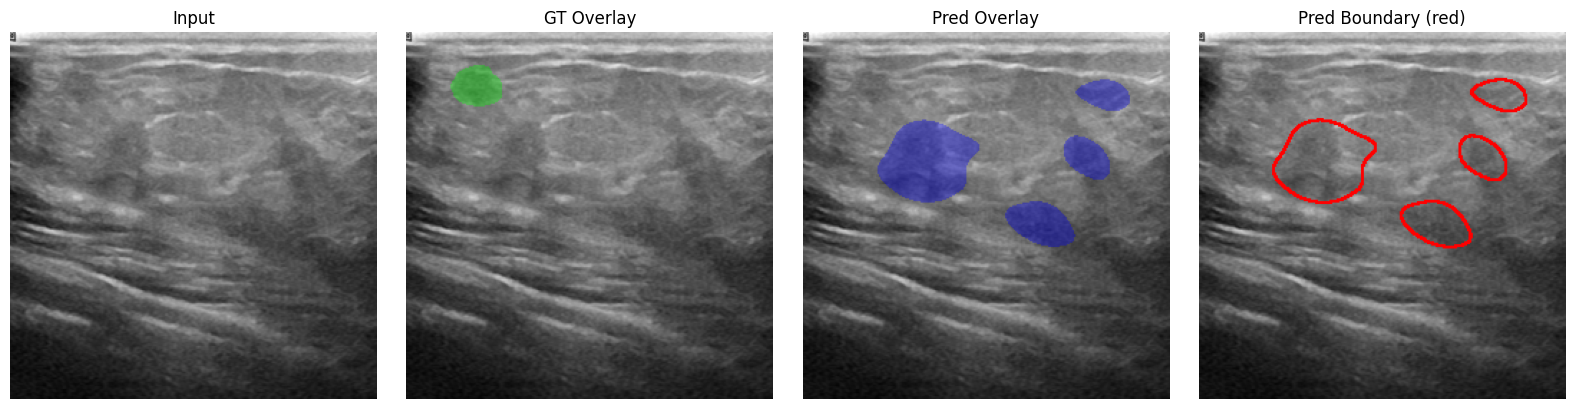

[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_testid0.png


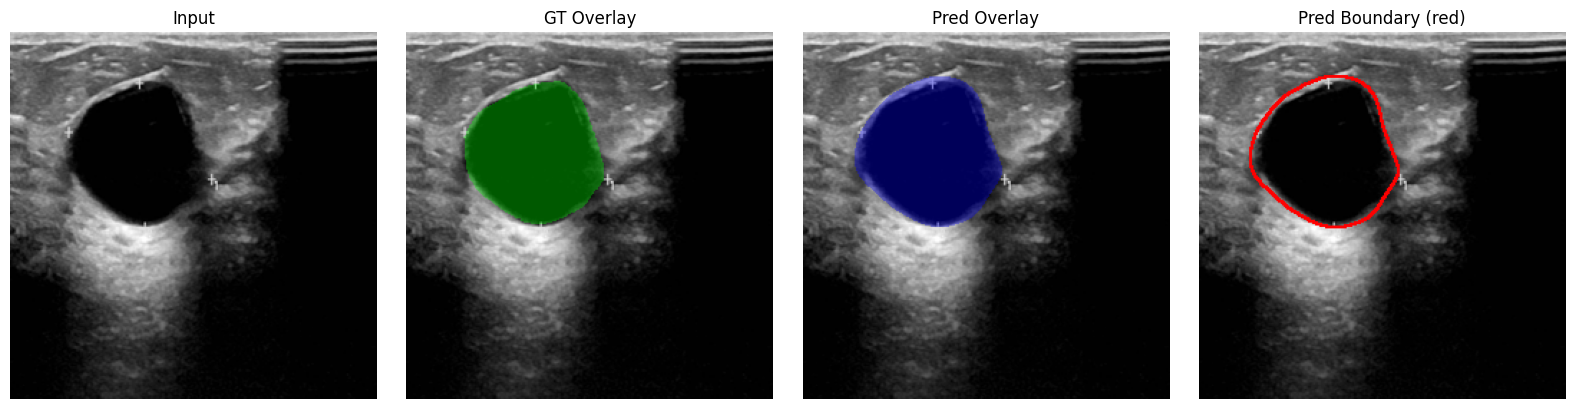

[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_testid1.png


In [58]:
# ============================================================
# STEP 10 — POST-TRAINING EVALUATION (TEST-ONLY)
# Cell 4/5 — Qualitative on Test: two examples (+ optional 12-grid)
# ------------------------------------------------------------
# Two fixed test examples: input, GT overlay, pred overlay, pred boundary.
# Optional: 12-image grid (commented).
# ============================================================
import matplotlib.pyplot as plt
import cv2

# Fallback helpers if missing
if "tensor_to_rgb" not in globals():
    def tensor_to_rgb(img_t):
        mean = np.array(NORM_MEAN, dtype=np.float32).reshape(3,1,1)
        std  = np.array(NORM_STD,  dtype=np.float32).reshape(3,1,1)
        img = img_t.detach().cpu().numpy()
        img = img * std + mean
        img = np.clip(img, 0.0, 1.0)
        img = (img * 255.0).round().astype(np.uint8)
        return np.transpose(img, (1,2,0))
if "overlay_mask" not in globals():
    def overlay_mask(image_rgb, mask_01, color=(0,255,0), alpha=0.35):
        overlay = image_rgb.copy().astype(np.float32)
        color_arr = np.array(color, dtype=np.float32).reshape(1,1,3)
        m = (mask_01.astype(np.float32)[...,None])
        overlay = overlay * (1 - alpha*m) + color_arr * (alpha*m)
        return overlay.clip(0,255).astype(np.uint8)
if "mask_boundary" not in globals():
    def mask_boundary(mask_01):
        m = (mask_01.astype(np.uint8) * 255)
        grad = cv2.morphologyEx(m, cv2.MORPH_GRADIENT, np.ones((3,3), np.uint8))
        return grad > 0
if "overlay_boundary" not in globals():
    def overlay_boundary(image_rgb, edge_bool, color=(255,0,0)):
        out = image_rgb.copy()
        out[edge_bool] = list(color)
        return out

# Deterministic fetch from NPZ using val_tf for preprocessing
def get_test_pair(global_idx: int):
    img = npz["test_images"][global_idx]
    for cand in ("test_masks","test_mask","test_labels","test_label"):
        if cand in npz:
            msk = npz[cand][global_idx]
            break
    else:
        raise KeyError("No test label key found among {test_masks, test_mask, test_labels, test_label}.")
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)
    if msk.max() > 1:
        msk = (msk > 127).astype(np.uint8)
    out = val_tf(image=img, mask=msk)
    img_t = out["image"]
    msk_t = out["mask"].unsqueeze(0).float() if out["mask"].ndim==2 else out["mask"].float()
    return img_t, msk_t

@torch.no_grad()
def predict_mask(img_t: torch.Tensor):
    x = img_t.unsqueeze(0).to(device)
    logits = _model_logits(model, x)
    prob = torch.sigmoid(logits)[0,0].detach().cpu().numpy()
    pred = (prob >= THRESH).astype(np.uint8)
    return prob, pred

def render_qual(global_idx: int, save_prefix: str):
    img_t, msk_t = get_test_pair(global_idx)
    rgb = tensor_to_rgb(img_t)
    gt  = (msk_t.squeeze(0).cpu().numpy() > 0.5).astype(np.uint8)

    prob, pred = predict_mask(img_t)
    over_gt   = overlay_mask(rgb, gt,   color=(0,255,0), alpha=0.35)
    over_pred = overlay_mask(rgb, pred, color=(0,0,255), alpha=0.35)
    edge_pred = overlay_boundary(rgb, mask_boundary(pred), color=(255,0,0))

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(rgb);        axes[0].set_title("Input");                axes[0].axis("off")
    axes[1].imshow(over_gt);    axes[1].set_title("GT Overlay");           axes[1].axis("off")
    axes[2].imshow(over_pred);  axes[2].set_title("Pred Overlay");         axes[2].axis("off")
    axes[3].imshow(edge_pred);  axes[3].set_title("Pred Boundary (red)");  axes[3].axis("off")
    plt.tight_layout()

    out_path = fig_dir / f"{save_prefix}_testid{global_idx}.png"
    fig.savefig(out_path, dpi=150)
    plt.show()
    plt.close(fig)
    print(f"[SAVE] {out_path}")

prefix = globals().get("RUN_NAME","run")
render_qual(PREVIEW_TEST_IDS[0], prefix)
render_qual(PREVIEW_TEST_IDS[1], prefix)



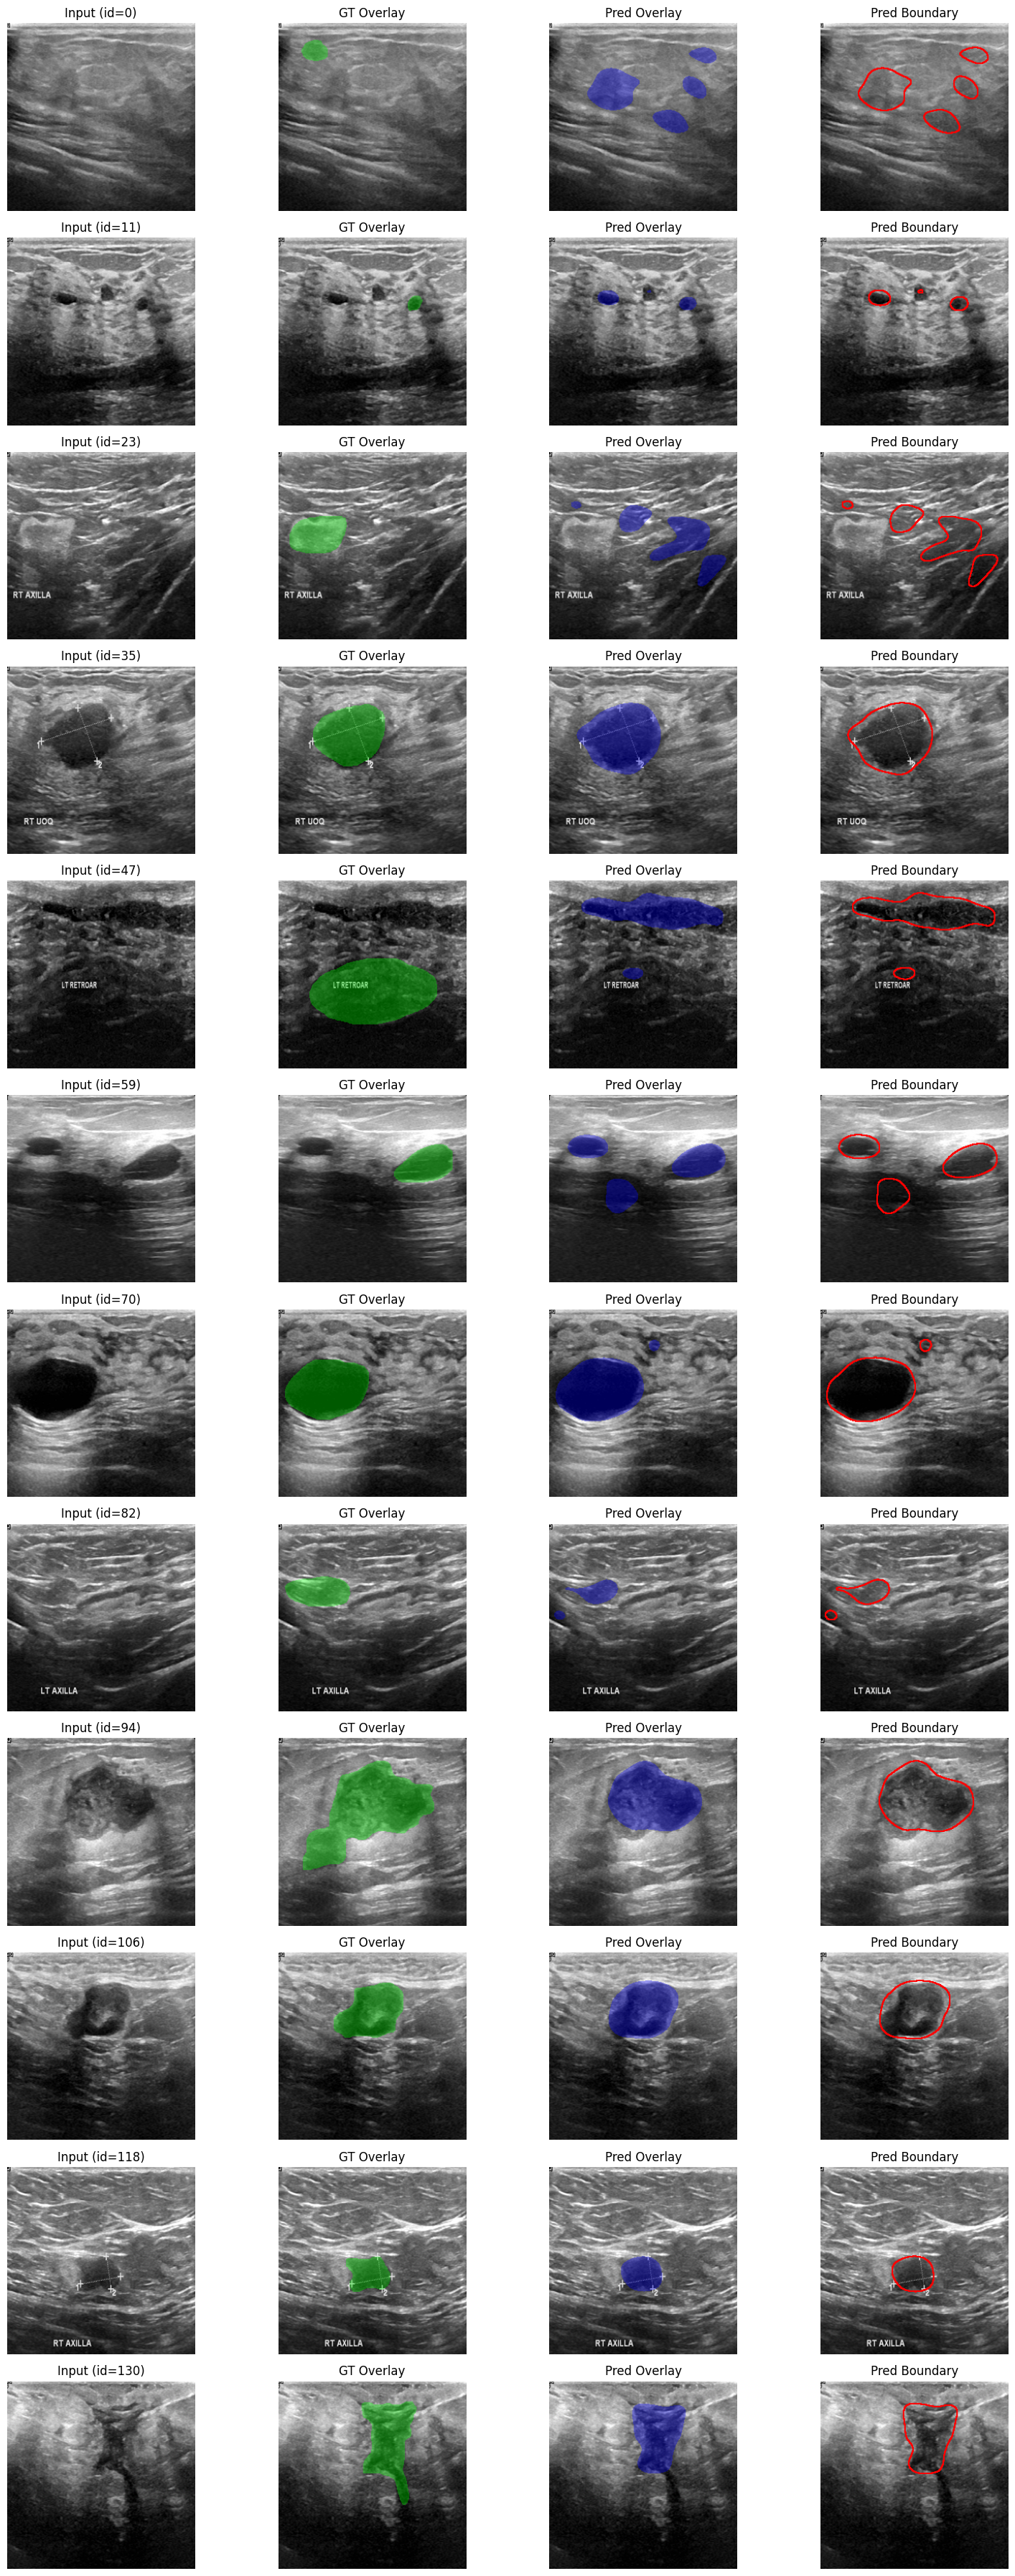

[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_test_grid_4panels_12.png


In [59]:
# ============================================================
# STEP 10 — POST-TRAINING EVALUATION (TEST-ONLY)
# Cell 5/5 — 12-image GRID (Input | GT Overlay | Pred Overlay | Pred Boundary)
# ------------------------------------------------------------
# Produces a 12×4 grid: for 12 test samples, each row shows:
#   [Input] [GT Overlay] [Pred Overlay] [Pred Boundary]
# Saves a PNG under figures/.
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

def render_test_grid_4panels(n_select=12):
    # how many test samples are available
    total = int(npz["test_images"].shape[0]) if "test_images" in npz else len(_split_idx["test"])
    n = min(n_select, total)
    # pick evenly spaced test indices
    sel = list(np.linspace(0, total-1, n, dtype=int))

    rows, cols = n, 4
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    if rows == 1:  # normalize axes shape for single row
        axes = np.expand_dims(axes, 0)

    for r, idx in enumerate(sel):
        # fetch data & predict
        img_t, msk_t = get_test_pair(int(idx))         # uses val_tf; defined in Step 13 Cell 4
        rgb = tensor_to_rgb(img_t)
        gt  = (msk_t.squeeze(0).cpu().numpy() > 0.5).astype(np.uint8)
        _, pred = predict_mask(img_t)                   # defined in Step 13 Cell 4

        # compose panels
        over_gt    = overlay_mask(rgb, gt,   color=(0,255,0), alpha=0.35)
        over_pred  = overlay_mask(rgb, pred, color=(0,0,255), alpha=0.35)
        edge_pred  = overlay_boundary(rgb, mask_boundary(pred), color=(255,0,0))

        # plot row: Input | GT Overlay | Pred Overlay | Pred Boundary
        axes[r,0].imshow(rgb);       axes[r,0].set_title(f"Input (id={idx})"); axes[r,0].axis("off")
        axes[r,1].imshow(over_gt);   axes[r,1].set_title("GT Overlay");        axes[r,1].axis("off")
        axes[r,2].imshow(over_pred); axes[r,2].set_title("Pred Overlay");      axes[r,2].axis("off")
        axes[r,3].imshow(edge_pred); axes[r,3].set_title("Pred Boundary");     axes[r,3].axis("off")

    plt.tight_layout()
    out_path = fig_dir / f"{globals().get('RUN_NAME','run')}_test_grid_4panels_{n}.png"
    fig.savefig(out_path, dpi=150)
    plt.show()
    plt.close(fig)
    print(f"[SAVE] {out_path}")

# ---- Run the 12×4 grid ----
render_test_grid_4panels(n_select=12)


# **Step # 11**

In [60]:
# ============================================================
# STEP 11 — INFERENCE SPEED TEST (APPLE-TO-APPLES, TEST-ONLY)
# Cell 1/2 — Setup: pick 50 fixed test indices, warmup, and helpers
# ------------------------------------------------------------
# Policy:
#   • Same device as training, model.eval(), grads off.
#   • Batch = 1, exactly 50 fixed test images (evenly spaced).
#   • Measure per-image latency (ms/img) and peak VRAM (MB).
# Notes:
#   • Uses get_test_pair() from Step 13; a safe fallback is defined if missing.
#   • AMP at inference can be toggled via AMP_INFER (default True on CUDA).
# ============================================================
from pathlib import Path
import time, json
import numpy as np
import torch

# Ensure eval mode
model.eval()
for p in model.parameters():
    p.requires_grad_(False)

# AMP inference flag (apples-to-apples across runs: keep constant)
AMP_INFER = bool(globals().get("AMP_INFER", True)) and torch.cuda.is_available()

# Evenly spaced 50 test indices
def _evenly_spaced_indices(total, n=50):
    n = min(n, total)
    if n <= 0: return []
    return list(np.linspace(0, total-1, n, dtype=int))

# Fallback get_test_pair if missing (uses val_tf)
if "get_test_pair" not in globals():
    def get_test_pair(global_idx: int):
        img = npz["test_images"][global_idx]
        for cand in ("test_masks","test_mask","test_labels","test_label"):
            if cand in npz:
                msk = npz[cand][global_idx]
                break
        else:
            raise KeyError("No test label key found among {test_masks, test_mask, test_labels, test_label}.")
        if img.ndim == 2:
            img = np.stack([img, img, img], axis=-1)
        if msk.max() > 1:
            msk = (msk > 127).astype(np.uint8)
        out = val_tf(image=img, mask=msk)
        img_t = out["image"]
        msk_t = out["mask"].unsqueeze(0).float() if out["mask"].ndim==2 else out["mask"].float()
        return img_t, msk_t

# Logits wrapper (same as Step 13)
@torch.no_grad()
def _model_logits(m, xb):
    out = m(xb)
    return out["logits"] if isinstance(out, dict) else out

# Prepare selection and warmup sample
total_test = int(npz["test_images"].shape[0]) if "test_images" in npz else len(_split_idx["test"])
SEL = _evenly_spaced_indices(total_test, n=50)

# Warmup (compile kernels, cache convs, etc.)
if len(SEL) > 0:
    xw, _ = get_test_pair(SEL[0])
    xw = xw.unsqueeze(0).to(device)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    with torch.no_grad(), torch.amp.autocast("cuda", enabled=AMP_INFER):
        _ = _model_logits(model, xw)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

print(f"[OK] Inference speed test setup: device={device}, AMP_INFER={AMP_INFER}, samples={len(SEL)}")


[OK] Inference speed test setup: device=cuda, AMP_INFER=True, samples=50


In [61]:
# ============================================================
# STEP 11 — INFERENCE SPEED TEST (APPLE-TO-APPLES, TEST-ONLY)
# Cell 2/2 — Timed loop (batch=1, 50 imgs): median latency & peak VRAM
# ------------------------------------------------------------
# Output:
#   • median latency (ms/img) across 50 fixed samples
#   • peak VRAM (MB) during inference
# Also saves a JSON summary under eval/.
# ============================================================
from pathlib import Path
import statistics as stats

latencies = []

# Reset peak VRAM stats
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# Timed forward passes
for idx in SEL:
    img_t, _ = get_test_pair(int(idx))
    x = img_t.unsqueeze(0).to(device)

    if device == "cuda":
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    with torch.no_grad(), torch.amp.autocast("cuda", enabled=AMP_INFER):
        _ = _model_logits(model, x)
    if device == "cuda":
        torch.cuda.synchronize()
    t1 = time.perf_counter()

    latencies.append((t1 - t0) * 1000.0)  # ms/img (batch=1)

# Aggregate
median_ms = float(stats.median(latencies)) if latencies else None
p95_ms    = float(np.percentile(latencies, 95)) if latencies else None
peak_vram_mb = (torch.cuda.max_memory_allocated() / (1024**2)) if torch.cuda.is_available() else None

print(f"[SPEED] median(ms/img)={median_ms:.2f}  p95(ms/img)={p95_ms:.2f}  peak_vram(MB)={peak_vram_mb:.1f}" if latencies else "[SPEED] No samples measured.")

# Save JSON
root    = Path(globals().get("root", "."))
eval_dir= root / "eval"
eval_dir.mkdir(parents=True, exist_ok=True)
run_name= globals().get("RUN_NAME","run")

speed_summary = {
    "run_name": run_name,
    "device": device,
    "amp_infer": AMP_INFER,
    "batch_size": 1,
    "num_samples": len(SEL),
    "median_latency_ms_per_img": median_ms,
    "p95_latency_ms_per_img": p95_ms,
    "peak_vram_mb": float(peak_vram_mb) if peak_vram_mb is not None else None,
    "indices": SEL,
}



[SPEED] median(ms/img)=35.60  p95(ms/img)=94.59  peak_vram(MB)=1619.1


# **Step # 12**

In [62]:
# ============================================================
# STEP 12 — THRESHOLD & CALIBRATION (TEST SET)
# Cell 1/6 — Collect test probabilities & labels (single pass)
# ------------------------------------------------------------
# Goal:
#   • Forward once over TEST to gather per-pixel probabilities (sigmoid(logits))
#     and ground-truth labels, flattened for PR/ROC/Calibration analysis.
#   • Save npz cache to avoid re-running heavy forward later.
# ============================================================
from pathlib import Path
import numpy as np
import torch

root    = Path(globals().get("root", "."))
fig_dir = root / "figures"
aux_dir = root / "aux"
fig_dir.mkdir(parents=True, exist_ok=True)
aux_dir.mkdir(parents=True, exist_ok=True)

cache_path = aux_dir / f"{globals().get('RUN_NAME','run')}_test_probs_labels.npz"

if cache_path.exists():
    data = np.load(cache_path)
    probs_all = data["probs_all"]
    gts_all   = data["gts_all"]
    print(f"[CACHE] Loaded: {cache_path.name}  (N={probs_all.size} pixels)")
else:
    probs_list, gts_list = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device, non_blocking=False)
            yb = yb.to(device, non_blocking=False).float()
            logits = model(xb)
            if isinstance(logits, dict): logits = logits["logits"]
            prob = torch.sigmoid(logits)
            probs_list.append(prob.detach().cpu().numpy().ravel())
            gts_list  .append(yb.detach().cpu().numpy().ravel())
    probs_all = np.concatenate(probs_list, axis=0)
    gts_all   = np.concatenate(gts_list,   axis=0)
    np.savez_compressed(cache_path, probs_all=probs_all, gts_all=gts_all)
    print(f"[OK] Saved cache → {cache_path}  (N={probs_all.size} pixels)")


[OK] Saved cache → /content/drive/MyDrive/unetr_model_busi/aux/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_test_probs_labels.npz  (N=8585216 pixels)


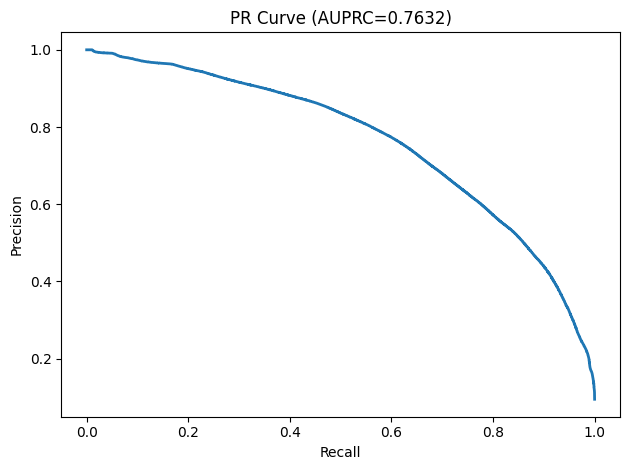

[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_PR_curve.png


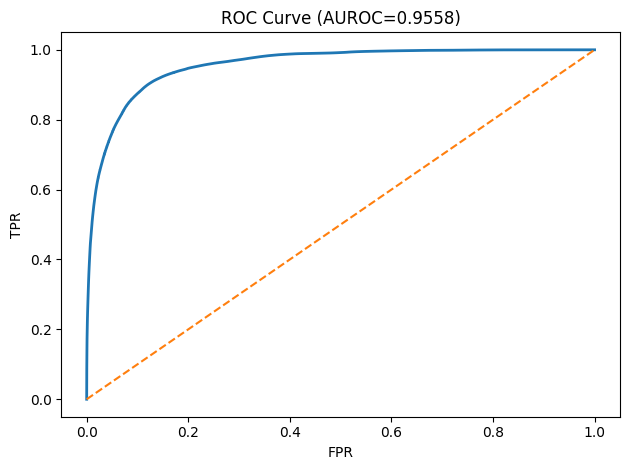

[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_ROC_curve.png
[METRICS] AUPRC=0.763167  AUROC=0.955783


In [63]:
# ============================================================
# STEP 12 — THRESHOLD & CALIBRATION
# Cell 2/6 — PR & ROC curves (AUPRC emphasized)
# ------------------------------------------------------------
# Goal:
#   • Compute PR + ROC; report AUPRC (more informative for imbalance) and AUROC.
#   • Save two separate figures (no subplots).
# ============================================================
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

# --- PR ---
prec, rec, _ = precision_recall_curve(gts_all, probs_all)
auprc = average_precision_score(gts_all, probs_all)

plt.figure()
plt.plot(rec, prec, linewidth=2)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR Curve (AUPRC={auprc:.4f})")
pr_path = fig_dir / f"{globals().get('RUN_NAME','run')}_PR_curve.png"
plt.tight_layout(); plt.savefig(pr_path, dpi=150); plt.show()
print(f"[SAVE] {pr_path}")

# --- ROC ---
fpr, tpr, _ = roc_curve(gts_all, probs_all)
auroc = roc_auc_score(gts_all, probs_all)

plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1], linestyle="--")  # chance line
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC Curve (AUROC={auroc:.4f})")
roc_path = fig_dir / f"{globals().get('RUN_NAME','run')}_ROC_curve.png"
plt.tight_layout(); plt.savefig(roc_path, dpi=150); plt.show()
print(f"[SAVE] {roc_path}")
print(f"[METRICS] AUPRC={auprc:.6f}  AUROC={auroc:.6f}")


In [ ]:
# ============================================================
# STEP 12 — THRESHOLD & CALIBRATION
# Cell 2/6 (Plotly) — PR & ROC curves (AUPRC emphasized)
# ------------------------------------------------------------
# Computes PR + ROC; reports AUPRC & AUROC.
# Saves interactive HTML (and PNG if kaleido is installed).
# ============================================================
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
import plotly.graph_objects as go
from pathlib import Path

# --- PR ---
prec, rec, _ = precision_recall_curve(gts_all, probs_all)
auprc = average_precision_score(gts_all, probs_all)

fig_pr = go.Figure()
fig_pr.add_trace(go.Scatter(x=rec, y=prec, mode="lines", name="PR"))
fig_pr.update_layout(
    title=f"PR Curve (AUPRC={auprc:.4f})",
    xaxis_title="Recall",
    yaxis_title="Precision",
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(l=40, r=20, t=60, b=40),
)
pr_html = fig_dir / f"{globals().get('RUN_NAME','run')}_PR_curve.html"
fig_pr.write_html(str(pr_html), include_plotlyjs="cdn")
fig_pr.show()
print(f"[SAVE] {pr_html}")

# Optional PNG (requires `pip install -U kaleido`)
try:
    pr_png = fig_dir / f"{globals().get('RUN_NAME','run')}_PR_curve.png"
    fig_pr.write_image(str(pr_png), scale=2)
    print(f"[SAVE] {pr_png}")
except Exception:
    pass

# --- ROC ---
fpr, tpr, _ = roc_curve(gts_all, probs_all)
auroc = roc_auc_score(gts_all, probs_all)

fig_roc = go.Figure()
fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode="lines", name="ROC"))
fig_roc.add_trace(go.Scatter(x=[0,1], y=[0,1], mode="lines", name="Chance", line=dict(dash="dash")))
fig_roc.update_layout(
    title=f"ROC Curve (AUROC={auroc:.4f})",
    xaxis_title="FPR",
    yaxis_title="TPR",
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(l=40, r=20, t=60, b=40),
)
roc_html = fig_dir / f"{globals().get('RUN_NAME','run')}_ROC_curve.html"
fig_roc.write_html(str(roc_html), include_plotlyjs="cdn")
fig_roc.show()
print(f"[SAVE] {roc_html}")

# Optional PNG
try:
    roc_png = fig_dir / f"{globals().get('RUN_NAME','run')}_ROC_curve.png"
    fig_roc.write_image(str(roc_png), scale=2)
    print(f"[SAVE] {roc_png}")
except Exception:
    pass

print(f"[METRICS] AUPRC={auprc:.6f}  AUROC={auroc:.6f}")


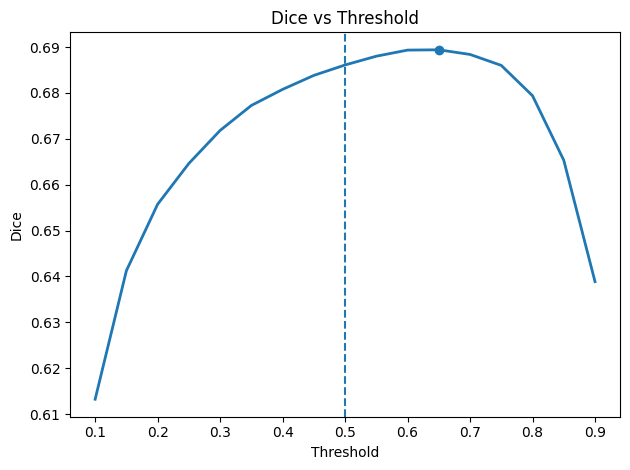

[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_Dice_vs_Threshold.png  |  Best Dice=0.6894 @ t=0.65  |  Marked THRESH=0.5


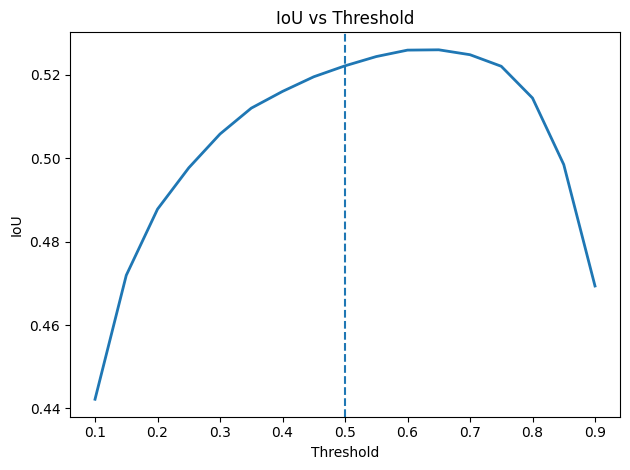

[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_IoU_vs_Threshold.png


In [64]:
# ============================================================
# STEP 12 — THRESHOLD & CALIBRATION
# Cell 3/6 — Threshold sweep (Dice & IoU vs threshold 0.1→0.9)
# ------------------------------------------------------------
# Goal:
#   • Plot Dice/IoU vs threshold; draw a vertical line at THRESH and mark best Dice.
#   • Uses aggregated pixel-wise Dice/IoU (fast & indicative).
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

def dice_iou_from_probs(probs, gts, t, eps=1e-6):
    pred = (probs >= t).astype(np.uint8)
    inter = (pred & gts.astype(np.uint8)).sum()
    p_sum = pred.sum(); g_sum = gts.sum()
    dice = (2*inter + eps) / (p_sum + g_sum + eps)
    union = p_sum + g_sum - inter
    iou = (inter + eps) / (union + eps)
    return float(dice), float(iou)

ths = np.linspace(0.1, 0.9, 17)
dice_vals, iou_vals = [], []
for t in ths:
    d, i = dice_iou_from_probs(probs_all, gts_all, t)
    dice_vals.append(d); iou_vals.append(i)

best_idx = int(np.argmax(dice_vals))
best_t, best_d = float(ths[best_idx]), float(dice_vals[best_idx])

# --- Dice vs threshold ---
plt.figure()
plt.plot(ths, dice_vals, linewidth=2)
plt.axvline(float(THRESH), linestyle="--")
plt.scatter([best_t],[best_d])
plt.xlabel("Threshold"); plt.ylabel("Dice"); plt.title("Dice vs Threshold")
dplot = fig_dir / f"{globals().get('RUN_NAME','run')}_Dice_vs_Threshold.png"
plt.tight_layout(); plt.savefig(dplot, dpi=150); plt.show()
print(f"[SAVE] {dplot}  |  Best Dice={best_d:.4f} @ t={best_t:.2f}  |  Marked THRESH={THRESH}")

# --- IoU vs threshold ---
plt.figure()
plt.plot(ths, iou_vals, linewidth=2)
plt.axvline(float(THRESH), linestyle="--")
plt.xlabel("Threshold"); plt.ylabel("IoU"); plt.title("IoU vs Threshold")
iplot = fig_dir / f"{globals().get('RUN_NAME','run')}_IoU_vs_Threshold.png"
plt.tight_layout(); plt.savefig(iplot, dpi=150); plt.show()
print(f"[SAVE] {iplot}")


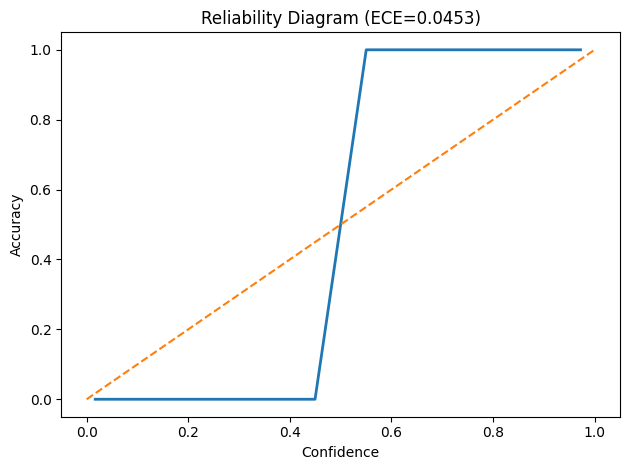

[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_Reliability_ECE.png  |  ECE=0.045279


In [65]:
# ============================================================
# STEP 12 — THRESHOLD & CALIBRATION
# Cell 4/6 — Reliability diagram + ECE
# ------------------------------------------------------------
# Goal:
#   • Bin probabilities, plot mean confidence vs empirical accuracy.
#   • Report Expected Calibration Error (ECE).
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

def reliability_bins(probs, gts, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx = np.digitize(probs, bins) - 1
    confs, accs, counts = [], [], []
    for b in range(n_bins):
        sel = (idx == b)
        if not np.any(sel):
            confs.append(np.nan); accs.append(np.nan); counts.append(0)
            continue
        p = probs[sel]; y = gts[sel].astype(np.uint8)
        confs.append(p.mean())
        accs.append((p >= 0.5).astype(np.uint8).mean())  # bin-wise accuracy
        counts.append(sel.sum())
    return np.array(confs), np.array(accs), np.array(counts), bins

def ece(confs, accs, counts):
    N = max(1, int(np.nansum(counts)))
    e = 0.0
    for c, a, n in zip(confs, accs, counts):
        if n <= 0 or np.isnan(c) or np.isnan(a): continue
        e += (n / N) * abs(a - c)
    return float(e)

confs, accs, counts, bins = reliability_bins(probs_all, gts_all, n_bins=10)
ece_val = ece(confs, accs, counts)

# Reliability plot
plt.figure()
mask = ~np.isnan(confs) & ~np.isnan(accs)
plt.plot(confs[mask], accs[mask], linewidth=2)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Confidence"); plt.ylabel("Accuracy"); plt.title(f"Reliability Diagram (ECE={ece_val:.4f})")
rel_path = fig_dir / f"{globals().get('RUN_NAME','run')}_Reliability_ECE.png"
plt.tight_layout(); plt.savefig(rel_path, dpi=150); plt.show()
print(f"[SAVE] {rel_path}  |  ECE={ece_val:.6f}")


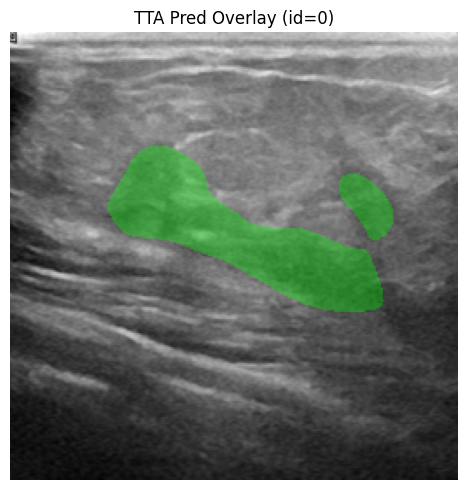

[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_TTA_pred_id0.png


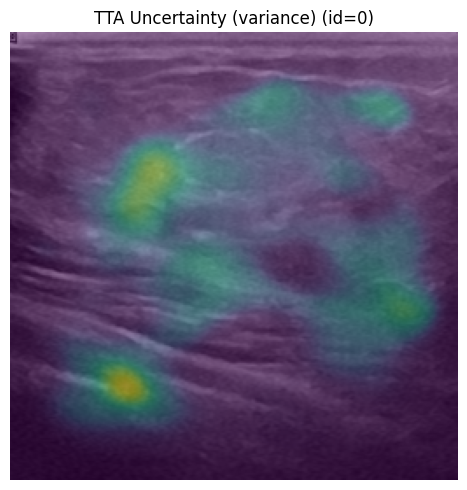

[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_TTA_uncertainty_id0.png


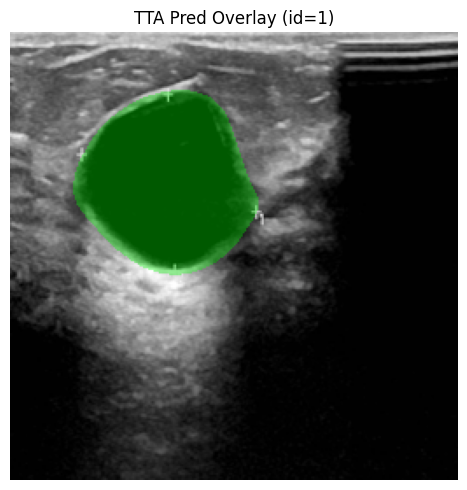

[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_TTA_pred_id1.png


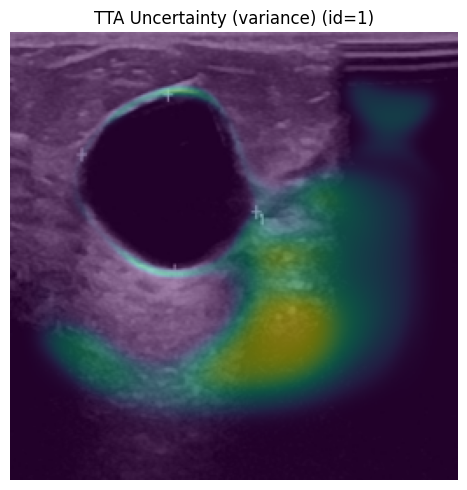

[SAVE] /content/drive/MyDrive/unetr_model_busi/figures/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_TTA_uncertainty_id1.png


In [66]:
# ============================================================
# STEP 12 — THRESHOLD & CALIBRATION
# Cell 5/6 — Uncertainty via TTA (flips): two fixed test examples
# ------------------------------------------------------------
# Goal:
#   • Use simple test-time augmentations (identity, hflip, vflip, hvflip).
#   • Aggregate mean prob and variance map; render uncertainty overlays.
# Notes:
#   • Uses PREVIEW_TEST_IDS from prior steps; falls back to [0,1] if missing.
# ============================================================
import matplotlib.pyplot as plt

if "PREVIEW_TEST_IDS" not in globals():
    PREVIEW_TEST_IDS = [0, 1]

@torch.no_grad()
def _prob_from_img_t(img_t):
    x = img_t.unsqueeze(0).to(device)
    out = model(x)
    logits = out["logits"] if isinstance(out, dict) else out
    p = torch.sigmoid(logits)[0,0].detach().cpu().numpy()
    return p

def _tta_flips(img_t):
    # returns list of (prob_map) in original orientation
    outs = []
    # identity
    outs.append(_prob_from_img_t(img_t))
    # hflip
    p = _prob_from_img_t(torch.flip(img_t, dims=[2]))
    outs.append(np.flip(p, axis=1))
    # vflip
    p = _prob_from_img_t(torch.flip(img_t, dims=[1]))
    outs.append(np.flip(p, axis=0))
    # hvflip
    p = _prob_from_img_t(torch.flip(img_t, dims=[1,2]))
    outs.append(np.flip(np.flip(p, axis=0), axis=1))
    return outs

def _get_test_pair(global_idx: int):
    img = npz["test_images"][global_idx]
    for cand in ("test_masks","test_mask","test_labels","test_label"):
        if cand in npz:
            msk = npz[cand][global_idx]
            break
    else:
        raise KeyError("No test label key found among {test_masks, test_mask, test_labels, test_label}.")
    if img.ndim == 2: img = np.stack([img, img, img], axis=-1)
    if msk.max() > 1: msk = (msk > 127).astype(np.uint8)
    out = val_tf(image=img, mask=msk)
    img_t = out["image"]
    msk_t = out["mask"].unsqueeze(0).float() if out["mask"].ndim==2 else out["mask"].float()
    return img_t, msk_t

# render two examples
for k, idx in enumerate(PREVIEW_TEST_IDS[:2]):
    img_t, msk_t = _get_test_pair(int(idx))
    rgb = tensor_to_rgb(img_t)
    gt  = (msk_t.squeeze(0).cpu().numpy() > 0.5).astype(np.uint8)

    plist = _tta_flips(img_t)
    p_mean = np.mean(plist, axis=0)
    p_var  = np.var(plist,  axis=0)

    pred = (p_mean >= THRESH).astype(np.uint8)
    over_gt   = overlay_mask(rgb, gt,   alpha=0.35)
    over_pred = overlay_mask(rgb, pred, alpha=0.35)

    plt.figure(figsize=(6,5))
    plt.imshow(over_pred); plt.title(f"TTA Pred Overlay (id={idx})"); plt.axis("off")
    tta_pred_path = fig_dir / f"{globals().get('RUN_NAME','run')}_TTA_pred_id{idx}.png"
    plt.tight_layout(); plt.savefig(tta_pred_path, dpi=150); plt.show()
    print(f"[SAVE] {tta_pred_path}")

    # uncertainty heatmap (variance)
    plt.figure(figsize=(6,5))
    plt.imshow(rgb); plt.imshow(p_var, alpha=0.5)
    plt.title(f"TTA Uncertainty (variance) (id={idx})"); plt.axis("off")
    tta_unc_path = fig_dir / f"{globals().get('RUN_NAME','run')}_TTA_uncertainty_id{idx}.png"
    plt.tight_layout(); plt.savefig(tta_unc_path, dpi=150); plt.show()
    print(f"[SAVE] {tta_unc_path}")


In [67]:
# ============================================================
# STEP 12 — THRESHOLD & CALIBRATION
# Cell 6/6 — Save a compact JSON with headline metrics
# ------------------------------------------------------------
# Goal:
#   • Persist AUPRC/AUROC, ECE, and best Dice threshold from sweep.
# ============================================================
import json
out_json = {
    "run_name": globals().get("RUN_NAME","run"),
    "auprc": float(auprc),
    "auroc": float(auroc),
    "threshold_policy": {
        "sweep_min": 0.1, "sweep_max": 0.9, "sweep_points": int(len(ths)),
        "chosen_thresh": float(THRESH),
        "best_dice": {"value": float(best_d), "at_thresh": float(best_t)}
    },
    "calibration": {"ece": float(ece_val), "n_bins": 10}
}
json_path = aux_dir / f"{globals().get('RUN_NAME','run')}_threshold_calibration_summary.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(out_json, f, indent=2)
print(f"[OK] Saved threshold/calibration summary → {json_path}")


[OK] Saved threshold/calibration summary → /content/drive/MyDrive/unetr_model_busi/aux/unetr_model_busi_IMG256_SEED42_2025-11-02_10-35-17_threshold_calibration_summary.json
